In [1]:
import trainExplainer
import trainExplainer_trainSplit
import sweepExplainerMUTAG
import importlib
import datasetLoader
import evaluation
import torch
import explainer
import networks
import wandb

importlib.reload(trainExplainer_trainSplit)
importlib.reload(datasetLoader)
importlib.reload(explainer)

<module 'explainer' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\explainer.py'>

In [2]:
data = datasetLoader.loadOriginalNodeDataset("Tree-Cycles")

In [6]:
dataNew, labels = datasetLoader.loadGraphDataset('BA-2Motif')

### Sweep config Tree-Cycles

In [ ]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_ind_AUC"},
    "parameters": {
        'epochs': {
            'values': [20]
            },
        'paper_loss': {
            'values': [1]
            },
        'tT': {
            'values': [1.0, 5.0]
            },
        'size_reg': {
            'values': [0.1, 0.05, 0.0001]
            },
        'entropy_reg': {
            'values': [10.0, 1.0, 0.01]
            },
        'lr_mlp':{
            'values': [0.003, 0.0003] #0.01
            },
        'sampled_graphs':{
            'values': [10]
            },
        'seed':{
            'values': [74, 75, 76]
            },
    },
}   

### Sweep config Tree-Grid

In [ ]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_ind_AUC"},
    "parameters": {
        'epochs': {
            'values': [30]
            },
        'paper_loss': {
            'values': [1]
            },
        'tT': {
            'values': [2.0, 5.0]    #og 5.0, re 2.0
            },
        'size_reg': {
            'values': [0.01, 1.0]
            },
        'entropy_reg': {
            'values': [1.0, 0.1]
            },
        'lr_mlp':{
            'values': [0.01, 0.003, 0.0003] #0.01
            },
        'sampled_graphs':{
            'values': [10]
            },
        'seed':{
            'values': [74, 75, 76]
            },
    },
}   

### Sweep config BA-Community

In [2]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_ind_AUC"},
    "parameters": {
        'epochs': {
            'values': [20]
            },
        'paper_loss': {
            'values': [1]
            },
        'tT': {
            'values': [1.0, 5.0]    #tmp = 1.0
            },
        'size_reg': {
            'values': [0.05, 0.1]   #og 0.05
            },
        'entropy_reg': {
            'values': [1.0, 0.1]    #og 1.0
            },
        'lr_mlp':{
            'values': [0.003]           # TODO: 0.01
            },
        'sampled_graphs':{
            'values': [10]
            },
        'sample_bias':{
            'values': [0.0, 0.5]
            },
        'seed':{
            'values': [74, 75, 76]
            },
    },
}   

### Sweep config BA-2Motif

In [2]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_ind_AUC"},
    "parameters": {
        'epochs': {
            'values': [20]
            },
        'paper_loss': {
            'values': [1, 0]
            },
        'tT': {
            'values': [1.0, 5.0]
            },
        'size_reg': {
            'values': [0.03]           # Try 0.0
            },
        'entropy_reg': {
            'values': [0.01]           # Try 0.0
            },
        'lr_mlp':{
            'values': [0.003, 0.0003]           
            },
        'sampled_graphs':{
            'values': [10]
            },
        'sample_bias':{
            'values': [0.0, 0.5]
            },
        'batch_size':{
            'values': [16, 64]
            },
        'seed':{
            'values': [74, 75, 76]
            },
    },
}   

### Sweep config MUTAG

In [2]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_ind_AUC"},
    "parameters": {
        'epochs': {
            'values': [10, 30]
            },
        'paper_loss': {
            'values': [1]
            },
        'tT': {
            'values': [1.0, 5.0]
            },
        'size_reg': {
            'values': [0.005]   #, 0.01
            },
        'entropy_reg': {
            'values': [0.1, 1.0]
            },
        'lr_mlp':{
            'values': [0.0003, 0.01]           
            },
        'sampled_graphs':{
            'values': [10]
            },
        'sample_bias':{
            'values': [0.0]     #, 0.5
            },
        'batch_size':{
            'values': [16, 64]
            },
        'seed':{
            'values': [74, 75, 76]
            },
    },
}   

In [ ]:
'L2_reg': {
            'values': [0.0, 0.01, 0.1, 1.0]
            },

In [3]:
sweep_id = wandb.sweep(sweep_config, project="Explainer-MUTAG-Sweep-FIN")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: oqddjxqr
Sweep URL: https://wandb.ai/tristan-schulz2001-tu-dortmund/Explainer-MUTAG-Sweep-FIN/sweeps/oqddjxqr


In [4]:
dataset="BA-2Motif"

In [4]:
wandb.agent(sweep_id, sweepExplainerMUTAG.trainExplainer)

wandb: Agent Starting Run: u4m5w5v3 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1
wandb: Currently logged in as: tristan-schulz2001 (tristan-schulz2001-tu-dortmund) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16137820482254028
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09385390367923119
roc_auc_score: 0.9061460963207688
Mean individual BinaryAUROC: 0.878322422504425
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08737120579225842
roc_auc_score: 0.9126287942077416
Mean individual BinaryAUROC: 0.8948794603347778
Epoch 2, Loss: 0.15500685572624207
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10151088731874758
roc_auc_score: 0.8984891126812524
Mean individual BinaryAUROC: 0.8672313690185547
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.0940690847489093
roc_auc_score: 0.9059309152510906
Mean individual BinaryAUROC: 0.880696713924408
Epoch 3, Loss: 0.15489821135997772
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11206093564172166
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▃▃▂▁▁
train/Loss,▅▄▄▄▁▁▆█▄▃
train/mean_ind_AUC,█▇▆▅▄▃▂▂▁▁
val/AUC,█▇▆▅▄▄▃▂▁▁
val/mean_ind_AUC,█▆▆▅▄▃▃▂▁▁
test/AUC,0.83319
test/mean_ind_AUC,0.80764
test/mean_infTime,0.00349


wandb: Agent Starting Run: boveb41h with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16177113354206085
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09354778939931778
roc_auc_score: 0.9064522106006823
Mean individual BinaryAUROC: 0.8791688680648804
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08715944954980043
roc_auc_score: 0.9128405504501995
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.1535867303609848
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10067685176855483
roc_auc_score: 0.8993231482314452
Mean individual BinaryAUROC: 0.86911541223526
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09365427457532721
roc_auc_score: 0.9063457254246727
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.15385980904102325
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11118224982853804
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▇▆▅▅▄▃▂▁
train/Loss,▆▅▅▄▁▂▆█▄▂
train/mean_ind_AUC,█▇▆▆▅▄▄▃▂▁
val/AUC,██▇▆▆▅▄▃▂▁
val/mean_ind_AUC,█▇▇▆▆▅▄▄▃▁
test/AUC,0.79219
test/mean_ind_AUC,0.77035
test/mean_infTime,0.00452


wandb: Agent Starting Run: wzp1j98u with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.222865492105484
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3082043001256975
roc_auc_score: 0.6917956998743024
Mean individual BinaryAUROC: 0.7176955342292786
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27155562517404624
roc_auc_score: 0.7284443748259537
Mean individual BinaryAUROC: 0.7614651918411255
Epoch 2, Loss: 0.22859062254428864
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31033290443770795
roc_auc_score: 0.6896670955622921
Mean individual BinaryAUROC: 0.7149158716201782
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27352524830595004
roc_auc_score: 0.72647475169405
Mean individual BinaryAUROC: 0.7559887170791626
Epoch 3, Loss: 0.20251430571079254
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31115105241742796
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▅▄▄▄▃▃▂▁▁
train/Loss,▇▇▅▁▁▄▆█▄▁
train/mean_ind_AUC,█▆▅▆▅▅▃▂▁▁
val/AUC,█▅▄▄▄▃▃▃▁▁
val/mean_ind_AUC,█▃▂▃▂▄▃▃▁▁
test/AUC,0.70847
test/mean_ind_AUC,0.72688
test/mean_infTime,0.00358


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8oi2lfiy with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22066102921962738
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30808842402728864
roc_auc_score: 0.6919115759727114
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2713960827995916
roc_auc_score: 0.7286039172004084
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.22678852081298828
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30950749356862894
roc_auc_score: 0.6904925064313711
Mean individual BinaryAUROC: 0.715332567691803
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727507425972338
roc_auc_score: 0.7272492574027662
Mean individual BinaryAUROC: 0.75789874792099
Epoch 3, Loss: 0.19877029955387115
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31008439807566446
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▅▄▃▃▃▃▂▁▁
train/Loss,▇█▆▂▁▄▆█▄▁
train/mean_ind_AUC,█▆▆▆▅▄▄▂▁▁
val/AUC,█▆▅▅▄▄▅▄▃▁
val/mean_ind_AUC,█▄▄▄▃▄▄▃▂▁
test/AUC,0.71047
test/mean_ind_AUC,0.72748
test/mean_infTime,0.00353


wandb: Agent Starting Run: 9pv7mfyz with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20314253866672516
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4423696744657443
roc_auc_score: 0.5576303255342557
Mean individual BinaryAUROC: 0.5991712808609009
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45688874965190757
roc_auc_score: 0.5431112503480925
Mean individual BinaryAUROC: 0.5727673768997192
Epoch 2, Loss: 0.20672950148582458
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.458554363139516
roc_auc_score: 0.5414456368604841
Mean individual BinaryAUROC: 0.5874723792076111
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4740323029796714
roc_auc_score: 0.5259676970203286
Mean individual BinaryAUROC: 0.5666764974594116
Epoch 3, Loss: 0.18852214515209198
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4724389855394222
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▃▃▂▂▁
train/Loss,▆▆▄█▂▄▁▇▁▄
train/mean_ind_AUC,█▇▇▅▄▃▃▂▁▁
val/AUC,█▇▆▅▄▃▃▂▂▁
val/mean_ind_AUC,██▇▅▅▄▃▃▁▁
test/AUC,0.44134
test/mean_ind_AUC,0.50325
test/mean_infTime,0.00357


wandb: Agent Starting Run: 1fvbvelf with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20037539303302765
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4394169385435761
roc_auc_score: 0.5605830614564239
Mean individual BinaryAUROC: 0.6012358069419861
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45337011510257125
roc_auc_score: 0.5466298848974287
Mean individual BinaryAUROC: 0.5753182768821716
Epoch 2, Loss: 0.20707711577415466
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4542344708283573
roc_auc_score: 0.5457655291716427
Mean individual BinaryAUROC: 0.5913709402084351
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.47017137751786875
roc_auc_score: 0.5298286224821313
Mean individual BinaryAUROC: 0.5684458017349243
Epoch 3, Loss: 0.18238985538482666
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4678008259885989
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▄▃▂▂▁
train/Loss,▆▆▄█▂▄▁▅▁▂
train/mean_ind_AUC,█▇▇▆▄▄▃▂▂▁
val/AUC,█▇▆▅▄▄▃▂▂▁
val/mean_ind_AUC,██▇▆▅▄▄▃▂▁
test/AUC,0.44455
test/mean_ind_AUC,0.50383
test/mean_infTime,0.00358


wandb: Agent Starting Run: igk3ot14 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16137820482254028
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3905888635146277
roc_auc_score: 0.6094111364853723
Mean individual BinaryAUROC: 0.5658175349235535
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43018715770908755
roc_auc_score: 0.5698128422909123
Mean individual BinaryAUROC: 0.5275530815124512
Epoch 2, Loss: 0.15263286232948303
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5389857457543047
roc_auc_score: 0.4610142542456953
Mean individual BinaryAUROC: 0.41317740082740784
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5713183421516755
roc_auc_score: 0.42868165784832446
Mean individual BinaryAUROC: 0.3587329089641571
Epoch 3, Loss: 0.14102603495121002
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5422403867818715
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▄▁▁▂▅████▇
train/Loss,▆▅▃▃▁▂▆█▄▃
train/mean_ind_AUC,▄▁▁▁▄█████
val/AUC,▃▁▁▁▅█████
val/mean_ind_AUC,▄▁▁▁▄█████
test/AUC,0.80913
test/mean_ind_AUC,0.76527
test/mean_infTime,0.00361


wandb: Agent Starting Run: dswo2ehi with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16177113354206085
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.37326678986067635
roc_auc_score: 0.6267332101393237
Mean individual BinaryAUROC: 0.5863136649131775
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.407999164578112
roc_auc_score: 0.592000835421888
Mean individual BinaryAUROC: 0.5499233603477478
Epoch 2, Loss: 0.15148741006851196
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5456315783826701
roc_auc_score: 0.45436842161732993
Mean individual BinaryAUROC: 0.4069627821445465
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5781467557783347
roc_auc_score: 0.42185324422166526
Mean individual BinaryAUROC: 0.3560982048511505
Epoch 3, Loss: 0.1420704573392868
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6101636295959441
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▃▂▁▂▃▄▅▇█
train/Loss,█▆▅▄▁▃▆▇▃▁
train/mean_ind_AUC,▅▂▁▁▁▂▄▅▆█
val/AUC,▅▂▁▁▂▃▄▅▇█
val/mean_ind_AUC,▅▂▂▁▂▂▄▅▇█
test/AUC,0.80323
test/mean_ind_AUC,0.78269
test/mean_infTime,0.00334


wandb: Agent Starting Run: ypm1wreg with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.222865492105484
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5762610810645745
roc_auc_score: 0.42373891893542553
Mean individual BinaryAUROC: 0.40964436531066895
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5884009793001022
roc_auc_score: 0.4115990206998979
Mean individual BinaryAUROC: 0.3857991695404053
Epoch 2, Loss: 0.2155589461326599
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7529202179857202
roc_auc_score: 0.24707978201427988
Mean individual BinaryAUROC: 0.2278604507446289
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.766467673814165
roc_auc_score: 0.23353232618583494
Mean individual BinaryAUROC: 0.18508216738700867
Epoch 3, Loss: 0.18446825444698334
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7561639646792485
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▄▁▁▁▂▃▄▆▇█
train/Loss,█▇▅▁▁▄▅▇▃▃
train/mean_ind_AUC,▄▁▁▁▂▃▄▅▆█
val/AUC,▄▁▁▁▂▃▄▅▆█
val/mean_ind_AUC,▄▁▁▁▂▃▄▅▆█
test/AUC,0.70367
test/mean_ind_AUC,0.66946
test/mean_infTime,0.00362


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lr33npmq with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22066102921962738
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5653419871760483
roc_auc_score: 0.43465801282395167
Mean individual BinaryAUROC: 0.42083290219306946
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5792751554812958
roc_auc_score: 0.4207248445187041
Mean individual BinaryAUROC: 0.3973608613014221
Epoch 2, Loss: 0.21729305386543274
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7281588410409371
roc_auc_score: 0.2718411589590629
Mean individual BinaryAUROC: 0.2505960464477539
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7467511371020142
roc_auc_score: 0.25324886289798565
Mean individual BinaryAUROC: 0.19906890392303467
Epoch 3, Loss: 0.18552452325820923
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7340265541138904
roc_auc_s

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▁▁▁▃▄▄▅▅▆
train/Loss,██▆▁▁▄▄▆▂▂
train/mean_ind_AUC,█▁▁▁▃▃▄▄▅▆
val/AUC,█▁▁▁▂▃▄▄▅▆
val/mean_ind_AUC,█▁▁▁▂▂▃▄▄▅
test/AUC,0.36061
test/mean_ind_AUC,0.34053
test/mean_infTime,0.00344


wandb: Agent Starting Run: liqo5urg with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20314253866672516
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7736003050413531
roc_auc_score: 0.2263996949586469
Mean individual BinaryAUROC: 0.2411755919456482
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8029680683189455
roc_auc_score: 0.19703193168105448
Mean individual BinaryAUROC: 0.1976410150527954
Epoch 2, Loss: 0.19858592748641968
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.801200852729237
roc_auc_score: 0.198799147270763
Mean individual BinaryAUROC: 0.17447853088378906
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8288052306692657
roc_auc_score: 0.17119476933073424
Mean individual BinaryAUROC: 0.1362006813287735
Epoch 3, Loss: 0.16848354041576385
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7977517643456508
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▁▁▁▂▂▃▄▆█
train/Loss,▆▆▃▄▁▅▃█▁▅
train/mean_ind_AUC,▂▁▁▁▂▂▃▄▆█
val/AUC,▁▁▁▁▂▂▃▄▆█
val/mean_ind_AUC,▃▁▁▁▁▂▃▄▆█
test/AUC,0.53857
test/mean_ind_AUC,0.53145
test/mean_infTime,0.00384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t90m61ra with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20037539303302765
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7234753915976624
roc_auc_score: 0.27652460840233767
Mean individual BinaryAUROC: 0.28400492668151855
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7545977211547387
roc_auc_score: 0.24540227884526133
Mean individual BinaryAUROC: 0.23036417365074158
Epoch 2, Loss: 0.20140019059181213
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7445744153167734
roc_auc_score: 0.2554255846832266
Mean individual BinaryAUROC: 0.22994570434093475
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7772672421795229
roc_auc_score: 0.22273275782047716
Mean individual BinaryAUROC: 0.180744007229805
Epoch 3, Loss: 0.16568154096603394
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7518805518805519
roc_auc_sc

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▂▁▁▁▂▃▄▆█
train/Loss,██▄▇▂▅▂▅▁▁
train/mean_ind_AUC,▅▂▂▁▁▂▃▄▆█
val/AUC,▂▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
test/AUC,0.36083
test/mean_ind_AUC,0.34948
test/mean_infTime,0.00369


wandb: Agent Starting Run: 6d2kxlxl with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16162467002868652
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09335169138662588
roc_auc_score: 0.9066483086133741
Mean individual BinaryAUROC: 0.8787989616394043
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08672433398310592
roc_auc_score: 0.9132756660168941
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.1539442241191864
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10073809113110423
roc_auc_score: 0.8992619088688958
Mean individual BinaryAUROC: 0.869136393070221
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09369488536155203
roc_auc_score: 0.906305114638448
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.15412241220474243
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11126536039199794
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/Loss,▃▃▃▂▁▁▃▄▃▁▂▅▆▃█▄▃▃▂▃▄▄▂▃▃▄▂▅▃▆
train/mean_ind_AUC,███▇▇▇▇▆▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/AUC,████▇▇▇▇▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▇▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test/AUC,0.52083
test/mean_ind_AUC,0.48538
test/mean_infTime,0.00364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6c98cfhc with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16177113354206085
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09354778939931778
roc_auc_score: 0.9064522106006823
Mean individual BinaryAUROC: 0.8791688680648804
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08715944954980043
roc_auc_score: 0.9128405504501995
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.1535867303609848
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10067685176855483
roc_auc_score: 0.8993231482314452
Mean individual BinaryAUROC: 0.86911541223526
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09365427457532721
roc_auc_score: 0.9063457254246727
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.15385980904102325
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11118224982853804
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▃▃▃▃▁▁▄▄▃▁▂▅▇▃█▄▄▃▂▃▅▄▂▃▃▃▂▅▃▆
train/mean_ind_AUC,███▇▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/AUC,████▇▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test/AUC,0.48289
test/mean_ind_AUC,0.45261
test/mean_infTime,0.00426


wandb: Agent Starting Run: of4ykaxm with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22129206359386444
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081081081081081
roc_auc_score: 0.6918918918918919
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2713786781769238
roc_auc_score: 0.7286213218230762
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.22734861075878143
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3095152103885728
roc_auc_score: 0.6904847896114272
Mean individual BinaryAUROC: 0.715397298336029
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727478418267892
roc_auc_score: 0.7272521581732108
Mean individual BinaryAUROC: 0.7581008076667786
Epoch 3, Loss: 0.19967854022979736
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31007841444522666
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█████████████████▇▇▇▇▆▅▄▄▃▂▂▁▁
train/Loss,▇▇▆▂▁▄▆█▄▁▃▄▇▆█▆▄▅▅▄▆▇▇▄▆▃▃▄▄▃
train/mean_ind_AUC,█████████████████▇▇▇▆▆▅▄▄▃▂▂▁▁
val/AUC,█████████████████▇▇▇▆▆▅▄▃▃▂▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▆▅▅▄▄▃▂▂▁▁
test/AUC,0.48543
test/mean_ind_AUC,0.51674
test/mean_infTime,0.0036


wandb: Agent Starting Run: qpx9qyqg with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22066102921962738
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30808842402728864
roc_auc_score: 0.6919115759727114
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2713960827995916
roc_auc_score: 0.7286039172004084
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.22678852081298828
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30950749356862894
roc_auc_score: 0.6904925064313711
Mean individual BinaryAUROC: 0.715332567691803
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727507425972338
roc_auc_score: 0.7272492574027662
Mean individual BinaryAUROC: 0.75789874792099
Epoch 3, Loss: 0.19877029955387115
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31008439807566446
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██████████████████▇▇▇▇▆▅▅▄▃▂▂▁
train/Loss,▇█▆▂▁▄▆█▄▁▃▄▇▆█▅▄▅▅▄▆▇▆▃▇▂▂▄▄▃
train/mean_ind_AUC,█████████████████▇▇▇▇▆▆▅▄▄▃▂▁▁
val/AUC,██████████████████▇▇▇▆▆▅▄▄▃▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▇▆▆▅▄▄▃▂▁▁
test/AUC,0.53738
test/mean_ind_AUC,0.57204
test/mean_infTime,0.00375


wandb: Agent Starting Run: yqnfrgre with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.2012978047132492
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4395666943701878
roc_auc_score: 0.5604333056298122
Mean individual BinaryAUROC: 0.6011866331100464
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45351515362480277
roc_auc_score: 0.5464848463751972
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 0.20687130093574524
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45526419172707383
roc_auc_score: 0.5447358082729261
Mean individual BinaryAUROC: 0.5908875465393066
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4710851202079272
roc_auc_score: 0.5289148797920727
Mean individual BinaryAUROC: 0.5680649280548096
Epoch 3, Loss: 0.18419861793518066
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4687710613474806
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▆▆▄█▂▄▂▆▁▃▄▃▅▇▄▁▅▄▄▅▃▄▆▇▇▇▃▇▆▅
train/mean_ind_AUC,██▇▇▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val/AUC,██▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.27299
test/mean_ind_AUC,0.33302
test/mean_infTime,0.00401


wandb: Agent Starting Run: sznnzisr with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20037539303302765
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4394169385435761
roc_auc_score: 0.5605830614564239
Mean individual BinaryAUROC: 0.6012358069419861
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45337011510257125
roc_auc_score: 0.5466298848974287
Mean individual BinaryAUROC: 0.5753182768821716
Epoch 2, Loss: 0.20707711577415466
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4542344708283573
roc_auc_score: 0.5457655291716427
Mean individual BinaryAUROC: 0.5913709402084351
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.47017137751786875
roc_auc_score: 0.5298286224821313
Mean individual BinaryAUROC: 0.5684458017349243
Epoch 3, Loss: 0.18238985538482666
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4678008259885989
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/Loss,▆▇▅█▃▄▂▆▂▃▄▃▅▆▄▁▅▄▄▄▃▃▆▆█▆▂▅▅▄
train/mean_ind_AUC,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
val/AUC,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
test/AUC,0.26658
test/mean_ind_AUC,0.32733
test/mean_infTime,0.00345


wandb: Agent Starting Run: 8ov564dg with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16162467002868652
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.38059661334770506
roc_auc_score: 0.619403386652295
Mean individual BinaryAUROC: 0.5771666169166565
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.41692773600668337
roc_auc_score: 0.5830722639933167
Mean individual BinaryAUROC: 0.5402455925941467
Epoch 2, Loss: 0.1517249494791031
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5438558432008214
roc_auc_score: 0.4561441567991786
Mean individual BinaryAUROC: 0.40894895792007446
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5763859881184442
roc_auc_score: 0.42361401188155573
Mean individual BinaryAUROC: 0.3566695749759674
Epoch 3, Loss: 0.1412307471036911
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6025279394275027
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▂▁▁▂▃▆▇██████▇▇▇▆▆▆▆▆▇▇▇▇▇██▇
train/Loss,▅▄▃▃▁▂▄▄▂▁▁▅▇▂█▄▂▃▂▄▄▅▂▃▃▃▂▆▄▇
train/mean_ind_AUC,▄▂▁▁▂▃▅▇██████▇▇▇▆▆▇▇▇▇▇▇▇████
val/AUC,▄▂▁▁▂▃▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇██▇
val/mean_ind_AUC,▅▂▂▁▂▃▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇████
test/AUC,0.81528
test/mean_ind_AUC,0.78938
test/mean_infTime,0.00342


wandb: Agent Starting Run: 7t2bz7sr with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.16177113354206085
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.37326678986067635
roc_auc_score: 0.6267332101393237
Mean individual BinaryAUROC: 0.5863136649131775
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.407999164578112
roc_auc_score: 0.592000835421888
Mean individual BinaryAUROC: 0.5499233603477478
Epoch 2, Loss: 0.15148741006851196
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5456315783826701
roc_auc_score: 0.45436842161732993
Mean individual BinaryAUROC: 0.4069627821445465
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5781467557783347
roc_auc_score: 0.42185324422166526
Mean individual BinaryAUROC: 0.3560982048511505
Epoch 3, Loss: 0.1420704573392868
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6101636295959441
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▂▁▁▂▃▄▅▆█████▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
train/Loss,▆▅▄▃▂▃▄▅▃▂▁▇█▂█▅▂▃▃▄▅▄▁▂▂▂▂█▃▆
train/mean_ind_AUC,▅▂▁▁▁▂▃▅▆█████▇▆▆▆▆▇▇▇██████▇▇
val/AUC,▅▂▁▁▂▂▄▅▆█████▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
val/mean_ind_AUC,▅▂▁▁▂▂▃▅▆█████▇▆▆▆▇▇▇▇████████
test/AUC,0.79195
test/mean_ind_AUC,0.75593
test/mean_infTime,0.0034


wandb: Agent Starting Run: qqoqe9h5 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22129206359386444
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5639877471755201
roc_auc_score: 0.4360122528244799
Mean individual BinaryAUROC: 0.4198511242866516
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5782743896778985
roc_auc_score: 0.4217256103221015
Mean individual BinaryAUROC: 0.3965562880039215
Epoch 2, Loss: 0.2167777270078659
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7264144270694489
roc_auc_score: 0.2735855729305511
Mean individual BinaryAUROC: 0.2527082562446594
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7439257866889446
roc_auc_score: 0.2560742133110554
Mean individual BinaryAUROC: 0.20102865993976593
Epoch 3, Loss: 0.1845424622297287
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7338707733904241
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▂▂▃▃▄▄▅▆▆▇▇▇▇████▇▇▇▇▇███
train/Loss,██▆▁▁▄▄▆▂▂▃▃▄▄▅▄▃▄▄▄▅▅▅▃▅▃▃▄▃▃
train/mean_ind_AUC,▃▁▁▁▂▂▂▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
val/AUC,▃▁▁▁▂▂▂▃▃▃▄▅▅▆▆▇▇▇████▇▇▇▇▇▇██
val/mean_ind_AUC,▃▁▁▁▁▂▂▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
test/AUC,0.79447
test/mean_ind_AUC,0.76951
test/mean_infTime,0.00337


wandb: Agent Starting Run: h6dl8zhl with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.22066102921962738
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5653419871760483
roc_auc_score: 0.43465801282395167
Mean individual BinaryAUROC: 0.42083290219306946
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5792751554812958
roc_auc_score: 0.4207248445187041
Mean individual BinaryAUROC: 0.3973608613014221
Epoch 2, Loss: 0.21729305386543274
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7281588410409371
roc_auc_score: 0.2718411589590629
Mean individual BinaryAUROC: 0.2505960464477539
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7467511371020142
roc_auc_score: 0.25324886289798565
Mean individual BinaryAUROC: 0.19906890392303467
Epoch 3, Loss: 0.18552452325820923
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7340265541138904
roc_auc_s

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇████
train/Loss,██▆▁▁▄▄▆▂▂▃▃▄▄▅▄▂▅▄▃▅▅▄▃▄▂▂▂▂▁
train/mean_ind_AUC,▄▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇████
val/AUC,▃▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇▇▇▇████
val/mean_ind_AUC,▄▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇████
test/AUC,0.7661
test/mean_ind_AUC,0.71289
test/mean_infTime,0.00328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7jsip27o with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.2012978047132492
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7247865494590385
roc_auc_score: 0.27521345054096147
Mean individual BinaryAUROC: 0.2812000513076782
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.755183676784554
roc_auc_score: 0.244816323215446
Mean individual BinaryAUROC: 0.22850312292575836
Epoch 2, Loss: 0.20054398477077484
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7490959766068936
roc_auc_score: 0.25090402339310636
Mean individual BinaryAUROC: 0.2244204878807068
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7815139701104613
roc_auc_score: 0.21848602988953866
Mean individual BinaryAUROC: 0.17622342705726624
Epoch 3, Loss: 0.16566626727581024
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7573063428958625
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▃▄▄▅▆▇████████▇▇▇▇▇▇▇▆
train/Loss,██▄▇▂▆▃▆▁▂▃▄▃▅▃▁▄▃▁▄▂▂▆▆██▁▆▅▃
train/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▄▄▅▆▇████████▇▇▇▇▇▇▇▆
val/AUC,▁▁▁▁▁▁▂▂▃▄▄▅▆▇███████████▇▇▇▇▆
val/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▃▄▅▆▇▇██████████▇▇▇▇▆
test/AUC,0.68266
test/mean_ind_AUC,0.62542
test/mean_infTime,0.00364


wandb: Agent Starting Run: 17iraeec with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.20037539303302765
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7234753915976624
roc_auc_score: 0.27652460840233767
Mean individual BinaryAUROC: 0.28400492668151855
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7545977211547387
roc_auc_score: 0.24540227884526133
Mean individual BinaryAUROC: 0.23036417365074158
Epoch 2, Loss: 0.20140019059181213
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7445744153167734
roc_auc_score: 0.2554255846832266
Mean individual BinaryAUROC: 0.22994570434093475
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7772672421795229
roc_auc_score: 0.22273275782047716
Mean individual BinaryAUROC: 0.180744007229805
Epoch 3, Loss: 0.16568154096603394
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7518805518805519
roc_auc_sc

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▆▆▇▇▇██████████
train/Loss,██▅▇▃▅▃▆▂▂▃▄▄▄▄▂▄▄▂▂▂▂▅▅▇▄▁▃▃▁
train/mean_ind_AUC,▂▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██████████
val/AUC,▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆▇▇▇██████████
val/mean_ind_AUC,▂▁▁▁▁▁▁▂▂▃▃▃▃▄▄▅▆▆▇▇██████████
test/AUC,0.77648
test/mean_ind_AUC,0.73948
test/mean_infTime,0.0034


wandb: Agent Starting Run: sk69nty1 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.1732315719127655
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.0938542750769825
roc_auc_score: 0.9061457249230175
Mean individual BinaryAUROC: 0.878322422504425
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08737120579225842
roc_auc_score: 0.9126287942077416
Mean individual BinaryAUROC: 0.8948794603347778
Epoch 2, Loss: 0.16672223806381226
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.1015105984538299
roc_auc_score: 0.8984894015461701
Mean individual BinaryAUROC: 0.8672313690185547
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09409229091246635
roc_auc_score: 0.9059077090875336
Mean individual BinaryAUROC: 0.880696713924408
Epoch 3, Loss: 0.16648654639720917
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11206192603572517
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▃▃▂▁▁
train/Loss,▅▄▄▄▁▁▆█▄▂
train/mean_ind_AUC,█▇▆▅▄▃▂▂▁▁
val/AUC,█▇▆▅▄▄▃▂▁▁
val/mean_ind_AUC,█▆▆▅▄▃▃▂▁▁
test/AUC,0.83256
test/mean_ind_AUC,0.80661
test/mean_infTime,0.00351


wandb: Agent Starting Run: kco9kjh9 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.173722505569458
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09354795446498504
roc_auc_score: 0.9064520455350149
Mean individual BinaryAUROC: 0.8791688680648804
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08715944954980043
roc_auc_score: 0.9128405504501995
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.16553395986557007
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10067330285670897
roc_auc_score: 0.899326697143291
Mean individual BinaryAUROC: 0.86911541223526
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09365427457532721
roc_auc_score: 0.9063457254246727
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.16582553088665009
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11119198870290574
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▆▅▅▄▃▂▁
train/Loss,▆▅▅▄▁▂▆█▄▂
train/mean_ind_AUC,█▇▆▆▅▄▄▃▂▁
val/AUC,██▇▆▆▅▄▃▂▁
val/mean_ind_AUC,█▇▇▆▆▅▄▄▃▁
test/AUC,0.79229
test/mean_ind_AUC,0.77044
test/mean_infTime,0.00328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xw6g5j3z with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.234717458486557
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30820401126077984
roc_auc_score: 0.6917959887392202
Mean individual BinaryAUROC: 0.7176955342292786
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27155562517404624
roc_auc_score: 0.7284443748259537
Mean individual BinaryAUROC: 0.7614651918411255
Epoch 2, Loss: 0.2402939349412918
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3103341424302123
roc_auc_score: 0.6896658575697877
Mean individual BinaryAUROC: 0.7149158716201782
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27352524830595004
roc_auc_score: 0.72647475169405
Mean individual BinaryAUROC: 0.7559887170791626
Epoch 3, Loss: 0.21405798196792603
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3111537760009376
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▅▄▄▄▃▃▂▁▁
train/Loss,▇▇▅▁▁▄▆█▄▁
train/mean_ind_AUC,█▆▅▆▅▅▃▂▁▁
val/AUC,█▅▄▄▄▃▃▂▁▁
val/mean_ind_AUC,█▃▂▃▂▄▃▃▁▁
test/AUC,0.70846
test/mean_ind_AUC,0.72688
test/mean_infTime,0.00329


wandb: Agent Starting Run: rl1ksmgp with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.2326117753982544
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3080885684597475
roc_auc_score: 0.6919114315402525
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2713960827995916
roc_auc_score: 0.7286039172004084
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.2387285977602005
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30950897915963416
roc_auc_score: 0.6904910208403658
Mean individual BinaryAUROC: 0.715332567691803
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727507425972338
roc_auc_score: 0.7272492574027662
Mean individual BinaryAUROC: 0.75789874792099
Epoch 3, Loss: 0.21071556210517883
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3101215378507955
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▅▄▃▃▃▃▂▁▁
train/Loss,▇█▆▂▁▄▆█▄▁
train/mean_ind_AUC,█▆▆▆▅▄▄▂▁▁
val/AUC,█▆▅▅▄▄▅▄▃▁
val/mean_ind_AUC,█▄▄▄▃▄▄▃▂▁
test/AUC,0.7105
test/mean_ind_AUC,0.72748
test/mean_infTime,0.00326


wandb: Agent Starting Run: cehcq18t with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.2149941325187683
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4426715795711429
roc_auc_score: 0.5573284204288571
Mean individual BinaryAUROC: 0.598844051361084
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4571034066648102
roc_auc_score: 0.5428965933351898
Mean individual BinaryAUROC: 0.5727673768997192
Epoch 2, Loss: 0.21843351423740387
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4589147840239543
roc_auc_score: 0.5410852159760456
Mean individual BinaryAUROC: 0.5871143341064453
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.47415993687923513
roc_auc_score: 0.5258400631207648
Mean individual BinaryAUROC: 0.5666764974594116
Epoch 3, Loss: 0.20008106529712677
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4727904309782039
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▃▃▂▁▁
train/Loss,▆▆▄█▃▄▁▆▁▄
train/mean_ind_AUC,█▇▇▅▄▃▃▂▁▁
val/AUC,█▇▆▅▄▃▃▂▁▁
val/mean_ind_AUC,██▇▅▄▄▃▃▁▁
test/AUC,0.44111
test/mean_ind_AUC,0.50266
test/mean_infTime,0.00353


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7jhuzfv with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21232599020004272
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4395061152703074
roc_auc_score: 0.5604938847296925
Mean individual BinaryAUROC: 0.6012358069419861
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4534339320523531
roc_auc_score: 0.5465660679476468
Mean individual BinaryAUROC: 0.5753182768821716
Epoch 2, Loss: 0.21901749074459076
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4543230698252532
roc_auc_score: 0.5456769301747468
Mean individual BinaryAUROC: 0.5912786722183228
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.47018298059964725
roc_auc_score: 0.5298170194003528
Mean individual BinaryAUROC: 0.5684458017349243
Epoch 3, Loss: 0.19434207677841187
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46789641964314455
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▅▄▄▃▂▂▁
train/Loss,▆▆▄█▂▄▁▅▁▂
train/mean_ind_AUC,█▇▇▆▄▄▃▂▂▁
val/AUC,█▇▆▅▄▄▃▂▂▁
val/mean_ind_AUC,██▇▆▅▄▄▃▂▁
test/AUC,0.44416
test/mean_ind_AUC,0.50383
test/mean_infTime,0.00328


wandb: Agent Starting Run: fp7vcoc0 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.1732315719127655
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.39072789007286823
roc_auc_score: 0.6092721099271318
Mean individual BinaryAUROC: 0.5656196475028992
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43042212011510256
roc_auc_score: 0.5695778798848974
Mean individual BinaryAUROC: 0.5275530815124512
Epoch 2, Loss: 0.16425572335720062
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5386165763895021
roc_auc_score: 0.4613834236104979
Mean individual BinaryAUROC: 0.4131428897380829
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5711529982363316
roc_auc_score: 0.4288470017636684
Mean individual BinaryAUROC: 0.3591829836368561
Epoch 3, Loss: 0.15238991379737854
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5437447540067627
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▄▁▁▂▄█████
train/Loss,▇▅▄▃▁▂▆█▃▂
train/mean_ind_AUC,▄▁▁▁▄▇████
val/AUC,▃▁▁▁▄█████
val/mean_ind_AUC,▄▁▁▁▄▇████
test/AUC,0.81802
test/mean_ind_AUC,0.77302
test/mean_infTime,0.00322


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15rmwb8a with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.173722505569458
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.37332070443424153
roc_auc_score: 0.6266792955657584
Mean individual BinaryAUROC: 0.5863136649131775
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.40809198923234014
roc_auc_score: 0.5919080107676599
Mean individual BinaryAUROC: 0.5499233603477478
Epoch 2, Loss: 0.16338343918323517
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5453354918420421
roc_auc_score: 0.4546645081579579
Mean individual BinaryAUROC: 0.4066604673862457
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5778711825860948
roc_auc_score: 0.4221288174139051
Mean individual BinaryAUROC: 0.35667574405670166
Epoch 3, Loss: 0.1539209634065628
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6090462588279182
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▃▂▁▂▃▄▅▇█
train/Loss,█▆▅▄▁▃▆▇▃▁
train/mean_ind_AUC,▅▂▁▁▁▂▄▅▆█
val/AUC,▅▂▁▁▂▃▄▅▇█
val/mean_ind_AUC,▅▂▂▁▂▂▄▅▇█
test/AUC,0.80256
test/mean_ind_AUC,0.7828
test/mean_infTime,0.0034


wandb: Agent Starting Run: afhbm8cb with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.234717458486557
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.576258563813149
roc_auc_score: 0.42374143618685106
Mean individual BinaryAUROC: 0.40960708260536194
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5883864754478789
roc_auc_score: 0.41161352455212097
Mean individual BinaryAUROC: 0.3857991695404053
Epoch 2, Loss: 0.22723764181137085
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7507052430633216
roc_auc_score: 0.24929475693667835
Mean individual BinaryAUROC: 0.22925588488578796
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7648432423651722
roc_auc_score: 0.2351567576348278
Mean individual BinaryAUROC: 0.1855107843875885
Epoch 3, Loss: 0.19581615924835205
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7536749394827997
roc_auc_sco

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▄▁▁▁▂▃▄▆▇█
train/Loss,█▇▅▁▁▄▅▆▃▃
train/mean_ind_AUC,▄▁▁▁▂▃▄▅▆█
val/AUC,▄▁▁▁▂▃▄▅▆█
val/mean_ind_AUC,▄▁▁▁▂▃▄▅▆█
test/AUC,0.71317
test/mean_ind_AUC,0.67951
test/mean_infTime,0.00366


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tuj1vt6p with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.2326117753982544
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5654442453569091
roc_auc_score: 0.43455575464309093
Mean individual BinaryAUROC: 0.42081424593925476
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5793099647266314
roc_auc_score: 0.42069003527336857
Mean individual BinaryAUROC: 0.3973608613014221
Epoch 2, Loss: 0.22921700775623322
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7270304934060392
roc_auc_score: 0.27296950659396074
Mean individual BinaryAUROC: 0.25155654549598694
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7454196834679291
roc_auc_score: 0.2545803165320709
Mean individual BinaryAUROC: 0.19989396631717682
Epoch 3, Loss: 0.19737844169139862
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7332780225793326
roc_auc_

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▁▁▁▃▄▄▅▅▆
train/Loss,██▆▁▁▄▄▆▂▂
train/mean_ind_AUC,█▁▁▁▃▃▄▄▅▆
val/AUC,█▁▁▁▂▃▄▅▅▆
val/mean_ind_AUC,█▁▁▁▂▂▃▄▄▅
test/AUC,0.36501
test/mean_ind_AUC,0.34413
test/mean_infTime,0.00324


wandb: Agent Starting Run: 6raoclbh with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.2149941325187683
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7781800107127618
roc_auc_score: 0.2218199892872382
Mean individual BinaryAUROC: 0.23686587810516357
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8068434976329714
roc_auc_score: 0.1931565023670287
Mean individual BinaryAUROC: 0.1972692757844925
Epoch 2, Loss: 0.21028491854667664
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8052786762393749
roc_auc_score: 0.19472132376062506
Mean individual BinaryAUROC: 0.1707884669303894
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8322745521210434
roc_auc_score: 0.16772544787895666
Mean individual BinaryAUROC: 0.1357232928276062
Epoch 3, Loss: 0.1803300529718399
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8017840709980448
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▂▂▃▄▆█
train/Loss,▇▆▃▅▁▅▃█▁▅
train/mean_ind_AUC,▂▁▁▁▂▂▃▄▆█
val/AUC,▁▁▁▁▂▂▃▄▆█
val/mean_ind_AUC,▃▁▁▁▁▂▃▄▆█
test/AUC,0.53973
test/mean_ind_AUC,0.53049
test/mean_infTime,0.00327


wandb: Agent Starting Run: xod99kmb with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21232599020004272
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.724417173762152
roc_auc_score: 0.2755828262378481
Mean individual BinaryAUROC: 0.2828022241592407
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7553316160772301
roc_auc_score: 0.24466838392276985
Mean individual BinaryAUROC: 0.23024038970470428
Epoch 2, Loss: 0.21333076059818268
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.745681717079097
roc_auc_score: 0.25431828292090297
Mean individual BinaryAUROC: 0.2277248352766037
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7784565580618212
roc_auc_score: 0.22154344193817876
Mean individual BinaryAUROC: 0.17990754544734955
Epoch 3, Loss: 0.17761565744876862
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7526193032743251
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▁▁▁▁▂▃▄▆█
train/Loss,██▄▇▂▅▂▅▁▁
train/mean_ind_AUC,▅▂▂▁▁▂▃▄▆█
val/AUC,▂▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
test/AUC,0.36152
test/mean_ind_AUC,0.34877
test/mean_infTime,0.00328


wandb: Agent Starting Run: 3psau3l6 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.17354640364646912
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09335177391945951
roc_auc_score: 0.9066482260805405
Mean individual BinaryAUROC: 0.8787989616394043
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08672433398310592
roc_auc_score: 0.913275666016894
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.16582795977592468
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10073982432061035
roc_auc_score: 0.8992601756793897
Mean individual BinaryAUROC: 0.869136393070221
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09368618305021814
roc_auc_score: 0.9063138169497819
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.16599464416503906
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11127575952903464
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/Loss,▃▃▃▂▁▁▃▄▂▁▂▅▆▃█▄▃▃▂▃▄▄▂▃▃▃▂▄▃▅
train/mean_ind_AUC,███▇▇▇▇▆▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/AUC,████▇▇▇▇▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▇▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test/AUC,0.52109
test/mean_ind_AUC,0.48618
test/mean_infTime,0.00331


wandb: Agent Starting Run: f96k87h2 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.173722505569458
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09354795446498504
roc_auc_score: 0.9064520455350149
Mean individual BinaryAUROC: 0.8791688680648804
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.08715944954980043
roc_auc_score: 0.9128405504501995
Mean individual BinaryAUROC: 0.895220935344696
Epoch 2, Loss: 0.16553395986557007
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10067330285670897
roc_auc_score: 0.899326697143291
Mean individual BinaryAUROC: 0.86911541223526
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09365427457532721
roc_auc_score: 0.9063457254246727
Mean individual BinaryAUROC: 0.882388174533844
Epoch 3, Loss: 0.16582553088665009
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11119198870290574
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▃▃▃▃▁▁▄▄▃▁▂▅▇▃█▄▄▃▂▃▅▄▂▃▃▃▂▅▃▆
train/mean_ind_AUC,███▇▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/AUC,████▇▇▇▇▇▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test/AUC,0.48317
test/mean_ind_AUC,0.45282
test/mean_infTime,0.00333


wandb: Agent Starting Run: hnip3dj2 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.23321297764778137
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30810827317377537
roc_auc_score: 0.6918917268262247
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2714076858813701
roc_auc_score: 0.7285923141186299
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.23922374844551086
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3095161182497427
roc_auc_score: 0.6904838817502573
Mean individual BinaryAUROC: 0.715397298336029
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727478418267892
roc_auc_score: 0.7272521581732108
Mean individual BinaryAUROC: 0.7581008076667786
Epoch 3, Loss: 0.21152372658252716
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3100822522219902
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█████████████████▇▇▇▇▆▅▄▄▃▂▂▁▁
train/Loss,▇▇▆▂▁▄▆█▄▁▃▄▇▆█▆▄▅▅▄▆▇▆▃▆▂▃▄▄▃
train/mean_ind_AUC,█████████████████▇▇▇▆▆▅▄▄▃▂▂▁▁
val/AUC,█████████████████▇▇▇▆▆▅▄▃▃▂▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▆▅▅▄▄▃▂▂▁▁
test/AUC,0.48597
test/mean_ind_AUC,0.51674
test/mean_infTime,0.00324


wandb: Agent Starting Run: 66o5meaz with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.2326117753982544
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3080885684597475
roc_auc_score: 0.6919114315402525
Mean individual BinaryAUROC: 0.7178066968917847
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2713960827995916
roc_auc_score: 0.7286039172004084
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 0.2387285977602005
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30950897915963416
roc_auc_score: 0.6904910208403658
Mean individual BinaryAUROC: 0.715332567691803
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2727507425972338
roc_auc_score: 0.7272492574027662
Mean individual BinaryAUROC: 0.75789874792099
Epoch 3, Loss: 0.21071556210517883
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3101215378507955
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██████████████████▇▇▇▇▆▅▅▄▃▂▂▁
train/Loss,▇█▆▂▁▄▆█▄▁▃▄▇▆█▅▄▅▅▄▆▇▆▃▇▂▂▄▄▃
train/mean_ind_AUC,█████████████████▇▇▇▇▆▆▅▄▄▃▂▁▁
val/AUC,██████████████████▇▇▇▆▆▅▄▄▃▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▇▆▆▅▄▄▃▂▁▁
test/AUC,0.53742
test/mean_ind_AUC,0.57204
test/mean_infTime,0.00326


wandb: Agent Starting Run: 8t4eelqy with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21321846544742584
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43960779572133285
roc_auc_score: 0.5603922042786671
Mean individual BinaryAUROC: 0.6011354327201843
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.453520955165692
roc_auc_score: 0.546479044834308
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 0.2187468260526657
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4553087594572311
roc_auc_score: 0.5446912405427689
Mean individual BinaryAUROC: 0.5908716320991516
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4710996240601504
roc_auc_score: 0.5289003759398496
Mean individual BinaryAUROC: 0.5680649280548096
Epoch 3, Loss: 0.196051225066185
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4689764030375384
roc_auc_score: 0.531

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▆▆▄█▃▄▂▆▁▃▄▃▅▇▄▁▅▄▄▅▃▄▆▇▇▇▃▇▆▄
train/mean_ind_AUC,██▇▇▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val/AUC,██▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
test/AUC,0.27255
test/mean_ind_AUC,0.33219
test/mean_infTime,0.0033


wandb: Agent Starting Run: 6mj5i4ri with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21232599020004272
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4395061152703074
roc_auc_score: 0.5604938847296925
Mean individual BinaryAUROC: 0.6012358069419861
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4534339320523531
roc_auc_score: 0.5465660679476468
Mean individual BinaryAUROC: 0.5753182768821716
Epoch 2, Loss: 0.21901749074459076
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4543230698252532
roc_auc_score: 0.5456769301747468
Mean individual BinaryAUROC: 0.5912786722183228
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.47018298059964725
roc_auc_score: 0.5298170194003528
Mean individual BinaryAUROC: 0.5684458017349243
Epoch 3, Loss: 0.19434207677841187
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46789641964314455
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train/Loss,▆▇▅█▃▄▂▆▂▃▄▃▅▆▄▁▅▄▄▄▃▃▆▆█▆▂▅▅▄
train/mean_ind_AUC,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
val/AUC,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
test/AUC,0.26586
test/mean_ind_AUC,0.32711
test/mean_infTime,0.00334


wandb: Agent Starting Run: 7hycrzqa with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.17354640364646912
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3806049904303179
roc_auc_score: 0.6193950095696821
Mean individual BinaryAUROC: 0.5771358609199524
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.41693933908846187
roc_auc_score: 0.5830606609115381
Mean individual BinaryAUROC: 0.5402455925941467
Epoch 2, Loss: 0.16354605555534363
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5434844248163025
roc_auc_score: 0.45651557518369745
Mean individual BinaryAUROC: 0.4089837372303009
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.576090109533092
roc_auc_score: 0.42390989046690797
Mean individual BinaryAUROC: 0.3566695749759674
Epoch 3, Loss: 0.1529550403356552
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6018644579779951
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▂▁▁▂▃▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train/Loss,▅▄▃▃▁▂▄▄▂▁▁▅▇▂█▄▂▃▂▄▄▅▂▃▃▃▂▆▃▆
train/mean_ind_AUC,▄▂▁▁▂▃▅▇███████▇▇▇▇▇▇▇▇▇▇▇▇██▇
val/AUC,▄▂▁▁▂▃▆▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val/mean_ind_AUC,▄▂▁▁▂▃▅▇███████▇▇▇▇▇▇▇▇▇▇▇███▇
test/AUC,0.78801
test/mean_ind_AUC,0.76101
test/mean_infTime,0.00336


wandb: Agent Starting Run: fzeo2fxs with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 0.173722505569458
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.37332070443424153
roc_auc_score: 0.6266792955657584
Mean individual BinaryAUROC: 0.5863136649131775
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.40809198923234014
roc_auc_score: 0.5919080107676599
Mean individual BinaryAUROC: 0.5499233603477478
Epoch 2, Loss: 0.16338343918323517
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5453354918420421
roc_auc_score: 0.4546645081579579
Mean individual BinaryAUROC: 0.4066604673862457
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5778711825860948
roc_auc_score: 0.4221288174139051
Mean individual BinaryAUROC: 0.35667574405670166
Epoch 3, Loss: 0.1539209634065628
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6090462588279182
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▅▂▁▁▁▂▄▅▆█████▇▇▆▇▇▇▇███▇▇▇▇▇▇
train/Loss,▆▅▄▄▂▃▅▅▃▂▁▇█▂█▅▂▃▃▄▅▄▁▂▂▂▂█▃▆
train/mean_ind_AUC,▅▂▁▁▁▂▃▅▆█████▇▇▆▇▇▇██████████
val/AUC,▅▂▁▁▂▂▃▅▆█████▇▇▆▇▇▇▇█████████
val/mean_ind_AUC,▅▂▁▁▂▂▃▅▆█████▇▇▆▇▇▇██████████
test/AUC,0.81204
test/mean_ind_AUC,0.77878
test/mean_infTime,0.00331


wandb: Agent Starting Run: j7biaaqh with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.23321297764778137
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5640461804217263
roc_auc_score: 0.4359538195782737
Mean individual BinaryAUROC: 0.4197694659233093
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5783440081685696
roc_auc_score: 0.4216559918314304
Mean individual BinaryAUROC: 0.3963794410228729
Epoch 2, Loss: 0.22863216698169708
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7253339484780533
roc_auc_score: 0.27466605152194673
Mean individual BinaryAUROC: 0.25377508997917175
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7425044091710759
roc_auc_score: 0.25749559082892415
Mean individual BinaryAUROC: 0.20491981506347656
Epoch 3, Loss: 0.19626536965370178
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7320352844370311
roc_auc_s

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇██████▇▇▇▇███
train/Loss,██▆▁▁▄▄▆▂▂▃▃▄▄▅▄▂▄▄▃▅▅▅▃▅▃▃▃▃▃
train/mean_ind_AUC,▃▁▁▁▂▂▂▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
val/AUC,▃▁▁▁▂▂▂▃▃▄▄▅▆▆▇▇▇█████▇▇▇▇▇███
val/mean_ind_AUC,▃▁▁▁▁▂▂▃▃▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██
test/AUC,0.80424
test/mean_ind_AUC,0.77912
test/mean_infTime,0.00349


wandb: Agent Starting Run: 299mj6mo with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 0.2326117753982544
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5654442453569091
roc_auc_score: 0.43455575464309093
Mean individual BinaryAUROC: 0.42081424593925476
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5793099647266314
roc_auc_score: 0.42069003527336857
Mean individual BinaryAUROC: 0.3973608613014221
Epoch 2, Loss: 0.22921700775623322
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7270304934060392
roc_auc_score: 0.27296950659396074
Mean individual BinaryAUROC: 0.25155654549598694
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7454196834679291
roc_auc_score: 0.2545803165320709
Mean individual BinaryAUROC: 0.19989396631717682
Epoch 3, Loss: 0.19737844169139862
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7332780225793326
roc_auc_

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇▇██████
train/Loss,██▆▁▁▄▄▆▂▂▃▃▄▄▅▄▂▄▄▃▅▄▄▂▄▂▂▂▂▁
train/mean_ind_AUC,▄▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇█████
val/AUC,▃▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇█████
val/mean_ind_AUC,▄▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████
test/AUC,0.78351
test/mean_ind_AUC,0.72882
test/mean_infTime,0.00335


wandb: Agent Starting Run: jx61ls2v with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21321846544742584
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7261720694035104
roc_auc_score: 0.2738279305964895
Mean individual BinaryAUROC: 0.28004372119903564
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7570039102385594
roc_auc_score: 0.24299608976144063
Mean individual BinaryAUROC: 0.22790251672267914
Epoch 2, Loss: 0.2124042958021164
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7497260735252002
roc_auc_score: 0.25027392647479985
Mean individual BinaryAUROC: 0.22368569672107697
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7821231319038336
roc_auc_score: 0.21787686809616633
Mean individual BinaryAUROC: 0.17545728385448456
Epoch 3, Loss: 0.177471324801445
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7574307611425516
roc_auc_sco

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▃▄▄▅▆▇██████████████▇▇
train/Loss,██▅▇▂▆▃▆▂▃▃▄▃▅▃▂▄▃▂▄▂▂▅▆▇▇▁▆▅▃
train/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▄▄▅▆▇███████████▇▇▇▇▇
val/AUC,▁▁▁▁▁▁▂▂▃▄▄▅▆▇██████████████▇▇
val/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▃▄▅▆▇▇████████████▇▇▇
test/AUC,0.77329
test/mean_ind_AUC,0.73355
test/mean_infTime,0.00326


wandb: Agent Starting Run: mfrmfxf8 with config:
wandb: 	batch_size: 16
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 0.21232599020004272
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.724417173762152
roc_auc_score: 0.2755828262378481
Mean individual BinaryAUROC: 0.2828022241592407
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7553316160772301
roc_auc_score: 0.24466838392276985
Mean individual BinaryAUROC: 0.23024038970470428
Epoch 2, Loss: 0.21333076059818268
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.745681717079097
roc_auc_score: 0.25431828292090297
Mean individual BinaryAUROC: 0.2277248352766037
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7784565580618212
roc_auc_score: 0.22154344193817876
Mean individual BinaryAUROC: 0.17990754544734955
Epoch 3, Loss: 0.17761565744876862
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7526193032743251
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▁▂▂▃▃▄▄▄▅▆▆▇▇▇██████████
train/Loss,██▅▇▃▆▃▆▂▂▃▄▄▄▄▂▄▄▂▂▂▂▅▅▇▄▁▃▃▁
train/mean_ind_AUC,▂▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██████████
val/AUC,▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▇▇▇██████████
val/mean_ind_AUC,▂▁▁▁▁▁▁▂▂▃▃▃▃▄▄▅▆▇▇▇██████████
test/AUC,0.79914
test/mean_ind_AUC,0.76574
test/mean_infTime,0.00348


wandb: Agent Starting Run: s3zkri31 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1328158378601074
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09808065768764458
roc_auc_score: 0.9019193423123554
Mean individual BinaryAUROC: 0.874155580997467
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09097106191404437
roc_auc_score: 0.9090289380859555
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.51495099067688
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10759824089518413
roc_auc_score: 0.8924017591048159
Mean individual BinaryAUROC: 0.8600592017173767
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09882054673721341
roc_auc_score: 0.9011794532627866
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.067201852798462
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11835018516241223
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▇▆▅▄▄▃▂▁
train/Loss,▄█▃▄▆▃▁▆▅▅
train/mean_ind_AUC,█▇▆▆▅▄▄▃▂▁
val/AUC,██▇▆▆▅▄▃▂▁
val/mean_ind_AUC,█▇▇▆▆▅▄▃▂▁
test/AUC,0.7499
test/mean_ind_AUC,0.73308
test/mean_infTime,0.00329


wandb: Agent Starting Run: ywnl9rj8 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1270813941955566
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09806382098958519
roc_auc_score: 0.9019361790104148
Mean individual BinaryAUROC: 0.8742293119430542
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105228348649401
roc_auc_score: 0.9089477165135059
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5033280849456787
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10778726171739272
roc_auc_score: 0.8922127382826073
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09894237909588786
roc_auc_score: 0.9010576209041121
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.057609796524048
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11879615132890242
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▆▆▅▄▄▂▁
train/Loss,▄█▃▄▆▃▁▅▅▄
train/mean_ind_AUC,█▇▇▆▅▅▄▃▂▁
val/AUC,██▇▇▆▅▅▄▂▁
val/mean_ind_AUC,█▇▇▇▆▆▅▄▃▁
test/AUC,0.71797
test/mean_ind_AUC,0.70347
test/mean_infTime,0.00332


wandb: Agent Starting Run: x70kiwg2 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3203790187835693
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078360386220648
roc_auc_score: 0.6921639613779351
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130035737491875
roc_auc_score: 0.7286996426250811
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.3706657886505127
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30804934473056744
roc_auc_score: 0.6919506552694326
Mean individual BinaryAUROC: 0.7167803049087524
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27143089204492715
roc_auc_score: 0.7285691079550729
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.5921247005462646
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30827193578285284
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▇▆▅▄▃▂▁▁
train/Loss,▂▂▅▂▁▃▃█▄▂
train/mean_ind_AUC,█▇▇▇▆▅▄▂▁▁
val/AUC,███▇▆▆▅▄▂▁
val/mean_ind_AUC,█▆▅▅▃▄▄▄▃▁
test/AUC,0.70976
test/mean_ind_AUC,0.73034
test/mean_infTime,0.00332


wandb: Agent Starting Run: nicy9u2m with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3011527061462402
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078268774775325
roc_auc_score: 0.6921731225224674
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.331716299057007
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3079702370095383
roc_auc_score: 0.6920297629904617
Mean individual BinaryAUROC: 0.7170666456222534
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.7286532302979671
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.527662992477417
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081329092246123
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▄▃▄▂▂▁▂
train/Loss,▃▃▆▂▁▃▃█▃▁
train/mean_ind_AUC,█▇▇▆▅▅▄▁▁▁
val/AUC,██▇▇▇▆▅▄▂▁
val/mean_ind_AUC,█▆▄▄▄▃▄▃▃▁
test/AUC,0.71097
test/mean_ind_AUC,0.73024
test/mean_infTime,0.00334


wandb: Agent Starting Run: vwti4u7t with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.127027988433838
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43930172270783624
roc_auc_score: 0.5606982772921637
Mean individual BinaryAUROC: 0.6012496948242188
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45318736656455955
roc_auc_score: 0.5468126334354404
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.2010953426361084
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4512212796055591
roc_auc_score: 0.5487787203944409
Mean individual BinaryAUROC: 0.593784511089325
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666179337231969
roc_auc_score: 0.5333820662768032
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.129657506942749
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4626475377567081
roc_auc_score: 0.537

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▆▅▄▃▃▂▁
train/Loss,▁▂▁▆▂█▆▆▄█
train/mean_ind_AUC,██▇▆▅▄▃▂▂▁
val/AUC,█▇▆▅▅▄▃▃▂▁
val/mean_ind_AUC,██▇▆▅▅▄▃▂▁
test/AUC,0.44666
test/mean_ind_AUC,0.50466
test/mean_infTime,0.00332


wandb: Agent Starting Run: wrdw6p0j with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.108588933944702
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4389916881183257
roc_auc_score: 0.5610083118816743
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843497
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.171588182449341
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4511487126115947
roc_auc_score: 0.5488512873884053
Mean individual BinaryAUROC: 0.5938665270805359
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4665715213960828
roc_auc_score: 0.5334284786039172
Mean individual BinaryAUROC: 0.5694814920425415
Epoch 3, Loss: 2.0691263675689697
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46263094865714954
roc_auc_score: 0.53

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▆▅▄▃▃▂▁
train/Loss,▁▂▁▆▁█▆▄▂▅
train/mean_ind_AUC,██▇▆▅▄▃▂▂▁
val/AUC,█▇▆▅▅▄▄▃▂▁
val/mean_ind_AUC,██▇▆▅▅▄▃▂▁
test/AUC,0.44159
test/mean_ind_AUC,0.50341
test/mean_infTime,0.00344


wandb: Agent Starting Run: 8nmzullr with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1328158378601074
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5133510476305236
roc_auc_score: 0.48664895236947636
Mean individual BinaryAUROC: 0.4453299939632416
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5518367678455398
roc_auc_score: 0.4481632321544602
Mean individual BinaryAUROC: 0.3943902850151062
Epoch 2, Loss: 2.376685857772827
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6061177875588356
roc_auc_score: 0.3938822124411644
Mean individual BinaryAUROC: 0.3436897099018097
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6454214239301959
roc_auc_score: 0.35457857606980414
Mean individual BinaryAUROC: 0.27621567249298096
Epoch 3, Loss: 1.8703539371490479
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6074615871559103
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▂▃▅▇███
train/Loss,▅█▁▃▄▃▁▅▃▅
train/mean_ind_AUC,▃▁▁▂▃▅▇███
val/AUC,▂▁▁▂▃▅▇███
val/mean_ind_AUC,▃▁▁▂▃▅▇███
test/AUC,0.83066
test/mean_ind_AUC,0.79081
test/mean_infTime,0.00332


wandb: Agent Starting Run: cm0x3thr with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1270813941955566
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5128520541184297
roc_auc_score: 0.48714794588157034
Mean individual BinaryAUROC: 0.44513216614723206
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.55097233825304
roc_auc_score: 0.44902766174696
Mean individual BinaryAUROC: 0.3941363990306854
Epoch 2, Loss: 2.3935232162475586
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6002705013622044
roc_auc_score: 0.39972949863779556
Mean individual BinaryAUROC: 0.3494759202003479
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6399273647080664
roc_auc_score: 0.36007263529193356
Mean individual BinaryAUROC: 0.2835370898246765
Epoch 3, Loss: 1.87977135181427
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6256396913602154
roc_auc_score: 0.374

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▄▂▁▁▁▂▃▄▆█
train/Loss,▅█▃▃▄▂▁▃▃▃
train/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
val/AUC,▃▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▁▁▁▁▂▃▄▆█
test/AUC,0.67235
test/mean_ind_AUC,0.62688
test/mean_infTime,0.00335


wandb: Agent Starting Run: 8xdazcay with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3203790187835693
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5548148004479883
roc_auc_score: 0.4451851995520118
Mean individual BinaryAUROC: 0.43064671754837036
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5691833751044277
roc_auc_score: 0.43081662489557226
Mean individual BinaryAUROC: 0.4089013338088989
Epoch 2, Loss: 2.2639760971069336
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6756466241182398
roc_auc_score: 0.32435337588176016
Mean individual BinaryAUROC: 0.3044939935207367
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6951029193353755
roc_auc_score: 0.3048970806646245
Mean individual BinaryAUROC: 0.25285130739212036
Epoch 3, Loss: 2.3263559341430664
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6935908302720529
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▃▄▆▇█
train/Loss,▅▄▅▁▁▃▄█▃▃
train/mean_ind_AUC,▃▁▁▁▂▃▄▅▇█
val/AUC,▃▁▁▁▂▃▄▅▇█
val/mean_ind_AUC,▃▁▁▁▂▃▄▅▇█
test/AUC,0.82987
test/mean_ind_AUC,0.82662
test/mean_infTime,0.00337


wandb: Agent Starting Run: e0n15w86 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3011527061462402
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5530010588962554
roc_auc_score: 0.4469989411037446
Mean individual BinaryAUROC: 0.4319327771663666
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5680027615334633
roc_auc_score: 0.4319972384665367
Mean individual BinaryAUROC: 0.4100204408168793
Epoch 2, Loss: 2.253286600112915
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6734560995478026
roc_auc_score: 0.32654390045219744
Mean individual BinaryAUROC: 0.3074473440647125
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.693208716235032
roc_auc_score: 0.306791283764968
Mean individual BinaryAUROC: 0.2571898102760315
Epoch 3, Loss: 2.344312906265259
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6897701790714891
roc_auc_score: 0.31

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▆▂▁▁▂▂▃▄▆█
train/Loss,▇▇█▃▂▃▂█▁▁
train/mean_ind_AUC,▇▂▁▁▁▂▃▄▆█
val/AUC,▇▂▁▁▂▂▃▅▆█
val/mean_ind_AUC,█▃▁▁▁▂▃▄▅▇
test/AUC,0.45665
test/mean_ind_AUC,0.42106
test/mean_infTime,0.00331


wandb: Agent Starting Run: xbhcgl2o with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.127027988433838
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7118789507435795
roc_auc_score: 0.28812104925642046
Mean individual BinaryAUROC: 0.2915765643119812
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7426784553977537
roc_auc_score: 0.2573215446022464
Mean individual BinaryAUROC: 0.2369944155216217
Epoch 2, Loss: 2.0919971466064453
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7316881100723895
roc_auc_score: 0.26831188992761046
Mean individual BinaryAUROC: 0.24156635999679565
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7628562146106006
roc_auc_score: 0.23714378538939943
Mean individual BinaryAUROC: 0.18982334434986115
Epoch 3, Loss: 1.9624085426330566
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7063278336204101
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▂▄▆███
train/Loss,▃▃▁▅▁▆▅▅▂█
train/mean_ind_AUC,▂▁▁▁▂▃▅▇██
val/AUC,▁▁▁▁▂▄▆███
val/mean_ind_AUC,▂▁▁▁▂▃▆▇██
test/AUC,0.85477
test/mean_ind_AUC,0.83514
test/mean_infTime,0.00335


wandb: Agent Starting Run: rybc2j97 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.108588933944702
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7109438124721967
roc_auc_score: 0.28905618752780327
Mean individual BinaryAUROC: 0.2925056219100952
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7417299034623596
roc_auc_score: 0.2582700965376404
Mean individual BinaryAUROC: 0.23751550912857056
Epoch 2, Loss: 2.0926249027252197
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.73168163124495
roc_auc_score: 0.26831836875505
Mean individual BinaryAUROC: 0.24146375060081482
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7631404901141743
roc_auc_score: 0.23685950988582566
Mean individual BinaryAUROC: 0.18802937865257263
Epoch 3, Loss: 1.9360027313232422
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7292664729345952
roc_auc_score: 0.2

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▁▁▁▁▂▃▄▆█
train/Loss,▄▄▂▆▁█▆▄▂▃
train/mean_ind_AUC,▃▁▁▁▁▂▃▄▆█
val/AUC,▂▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
test/AUC,0.41963
test/mean_ind_AUC,0.40187
test/mean_infTime,0.00326


wandb: Agent Starting Run: f4xjqqv5 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.128777503967285
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.0980816893480649
roc_auc_score: 0.9019183106519351
Mean individual BinaryAUROC: 0.8741897940635681
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105808502738327
roc_auc_score: 0.9089419149726167
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.507122278213501
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10762661155674257
roc_auc_score: 0.8923733884432574
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09891047062099693
roc_auc_score: 0.9010895293790031
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.05898118019104
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.118636656627923
roc_auc_score: 0.881

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/Loss,▄▇▃▃▅▃▁▅▄▃▃▇▃▆▇▅▅▅▃▅▆▄▅▅▅▅▄█▆▆
train/mean_ind_AUC,██▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/AUC,███▇▇▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test/AUC,0.48309
test/mean_ind_AUC,0.45498
test/mean_infTime,0.00333


wandb: Agent Starting Run: d504rjkw with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1270813941955566
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09806382098958519
roc_auc_score: 0.9019361790104148
Mean individual BinaryAUROC: 0.8742293119430542
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105228348649401
roc_auc_score: 0.9089477165135059
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5033280849456787
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10778726171739272
roc_auc_score: 0.8922127382826073
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09894237909588786
roc_auc_score: 0.9010576209041121
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.057609796524048
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11879615132890242
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train/Loss,▄▇▃▃▆▃▁▅▄▃▃▆▃▆▇▅▅▅▃▅▆▄▅▅▅▄▃█▅▅
train/mean_ind_AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
test/AUC,0.45961
test/mean_ind_AUC,0.43921
test/mean_infTime,0.00352


wandb: Agent Starting Run: 18d5gpmk with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3071672916412354
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078289614315815
roc_auc_score: 0.6921710385684184
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.3428235054016113
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3079813789420776
roc_auc_score: 0.6920186210579223
Mean individual BinaryAUROC: 0.716964840888977
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.7286532302979671
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.5448689460754395
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081588658007872
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,████████████████▇▇▇▆▆▅▅▄▃▃▂▂▁▁
train/Loss,▄▄▆▃▂▄▄█▄▂▁▅▃▅▆▅▄▅▄▂▆▇▆▆▆▃▆▇▇▂
train/mean_ind_AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▂▁
val/AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▁▁
val/mean_ind_AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▁▁
test/AUC,0.44216
test/mean_ind_AUC,0.469
test/mean_infTime,0.00337


wandb: Agent Starting Run: g85f78hy with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3011527061462402
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078268774775325
roc_auc_score: 0.6921731225224674
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.331716299057007
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3079702370095383
roc_auc_score: 0.6920297629904617
Mean individual BinaryAUROC: 0.7170666456222534
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.7286532302979671
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.527662992477417
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081329092246123
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█████████████████▇▇▇▆▆▅▅▄▃▃▂▁▁
train/Loss,▄▅▆▄▃▄▄█▄▃▂▅▄▅▆▅▄▄▄▂▆▆▆▅▅▂▆▆▇▁
train/mean_ind_AUC,█████████████████▇▇▇▆▆▅▄▄▃▃▂▁▁
val/AUC,█████████████████▇▇▇▆▅▅▄▄▃▂▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▆▅▅▄▄▃▃▂▂▁
test/AUC,0.47561
test/mean_ind_AUC,0.51005
test/mean_infTime,0.00338


wandb: Agent Starting Run: s9odn57k with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1147119998931885
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43899730035101214
roc_auc_score: 0.5610026996489879
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843498
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.179884433746338
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4512595748403609
roc_auc_score: 0.5487404251596392
Mean individual BinaryAUROC: 0.5937472581863403
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666788499025341
roc_auc_score: 0.5333211500974658
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.088022470474243
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46290198648277253
roc_auc_score: 0.5

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/Loss,▁▂▁▅▁▇▅▄▂▅▃▂▅▆▅▃▃▆▃▃▅▄▅█▆▇▇▅▇▄
train/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val/AUC,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁
test/AUC,0.26643
test/mean_ind_AUC,0.31411
test/mean_infTime,0.00344


wandb: Agent Starting Run: bmq1uom5 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.108588933944702
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4389916881183257
roc_auc_score: 0.5610083118816743
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843497
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.171588182449341
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4511487126115947
roc_auc_score: 0.5488512873884053
Mean individual BinaryAUROC: 0.5938665270805359
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4665715213960828
roc_auc_score: 0.5334284786039172
Mean individual BinaryAUROC: 0.5694814920425415
Epoch 3, Loss: 2.0691263675689697
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46263094865714954
roc_auc_score: 0.53

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▁▂▁▆▁█▆▄▂▅▄▂▅▆▅▃▃▆▃▃▄▃▄█▆▆▇▄▅▂
train/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val/AUC,██▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
test/AUC,0.25852
test/mean_ind_AUC,0.30468
test/mean_infTime,0.00335


wandb: Agent Starting Run: wfllzgde with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.128777503967285
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5128288211257643
roc_auc_score: 0.48717117887423567
Mean individual BinaryAUROC: 0.44527918100357056
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5509433305485937
roc_auc_score: 0.4490566694514063
Mean individual BinaryAUROC: 0.39493560791015625
Epoch 2, Loss: 2.385998010635376
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6013301816795267
roc_auc_score: 0.3986698183204733
Mean individual BinaryAUROC: 0.348398357629776
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6411224821312541
roc_auc_score: 0.358877517868746
Mean individual BinaryAUROC: 0.2825269103050232
Epoch 3, Loss: 1.8687020540237427
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6233971504713863
roc_auc_score: 0.37

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▃▅▇██████▇▇▇▇▆▆▆▆▆▆▆▇▇▇█
train/Loss,▅▇▂▃▄▃▂▃▃▃▁▅▂▄▆▃▃▄▃▄▅▃▄▄▄▄▃█▅▆
train/mean_ind_AUC,▃▁▁▁▁▂▃▅▆▇█████▇▇▇▇▆▆▆▆▆▆▆▇▇▇█
val/AUC,▃▁▁▁▁▂▃▅▇███████▇▇▇▇▆▆▆▆▆▆▇▇▇█
val/mean_ind_AUC,▃▁▁▁▁▂▃▅▇▇████▇▇▇▇▇▆▆▆▆▆▆▆▇▇██
test/AUC,0.82474
test/mean_ind_AUC,0.79156
test/mean_infTime,0.00336


wandb: Agent Starting Run: qtykth3f with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1270813941955566
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5128520541184297
roc_auc_score: 0.48714794588157034
Mean individual BinaryAUROC: 0.44513216614723206
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.55097233825304
roc_auc_score: 0.44902766174696
Mean individual BinaryAUROC: 0.3941363990306854
Epoch 2, Loss: 2.3935232162475586
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6002705013622044
roc_auc_score: 0.39972949863779556
Mean individual BinaryAUROC: 0.3494759202003479
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6399273647080664
roc_auc_score: 0.36007263529193356
Mean individual BinaryAUROC: 0.2835370898246765
Epoch 3, Loss: 1.87977135181427
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6256396913602154
roc_auc_score: 0.374

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▂▃▅▆▇██████████████▇▇▇▇▇
train/Loss,▅█▃▃▄▃▁▄▄▃▁▅▂▄▅▃▂▃▁▃▅▁▃▂▂▁▁▆▃▃
train/mean_ind_AUC,▃▁▁▁▁▂▂▃▄▆▇███████████████████
val/AUC,▃▁▁▁▁▂▂▃▅▆▇███████████████████
val/mean_ind_AUC,▃▁▁▁▁▂▂▃▅▆▇███████████████████
test/AUC,0.80098
test/mean_ind_AUC,0.75101
test/mean_infTime,0.0034


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s8mtfgh3 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3071672916412354
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5533648842600808
roc_auc_score: 0.44663511573991926
Mean individual BinaryAUROC: 0.4328020215034485
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5679940592221294
roc_auc_score: 0.4320059407778706
Mean individual BinaryAUROC: 0.40933576226234436
Epoch 2, Loss: 2.255932331085205
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6717929185178093
roc_auc_score: 0.32820708148219063
Mean individual BinaryAUROC: 0.3077792525291443
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6924081035923141
roc_auc_score: 0.30759189640768586
Mean individual BinaryAUROC: 0.2577517032623291
Epoch 3, Loss: 2.3361685276031494
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6899238139412812
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▃▃▄▅▆▇███████████▇▇▇▇▇▆▇
train/Loss,▇▆▇▃▃▄▃▇▂▂▂▃▁▃▅▃▂▅▃▂▄▆▅▆▆▃▆█▇▃
train/mean_ind_AUC,▃▁▁▁▁▂▂▃▄▅▆▇▇████████▇▇▇▇▆▆▆▆▆
val/AUC,▃▁▁▁▁▂▂▃▄▅▆▇███████████▇▇▇▇▆▆▇
val/mean_ind_AUC,▃▂▁▁▁▂▂▃▄▅▆▇▇█████████▇▇▇▇▆▆▆▇
test/AUC,0.71552
test/mean_ind_AUC,0.67582
test/mean_infTime,0.00331


wandb: Agent Starting Run: u1kork55 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3011527061462402
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5530010588962554
roc_auc_score: 0.4469989411037446
Mean individual BinaryAUROC: 0.4319327771663666
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5680027615334633
roc_auc_score: 0.4319972384665367
Mean individual BinaryAUROC: 0.4100204408168793
Epoch 2, Loss: 2.253286600112915
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6734560995478026
roc_auc_score: 0.32654390045219744
Mean individual BinaryAUROC: 0.3074473440647125
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.693208716235032
roc_auc_score: 0.306791283764968
Mean individual BinaryAUROC: 0.2571898102760315
Epoch 3, Loss: 2.344312906265259
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6897701790714891
roc_auc_score: 0.31

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▇▇███████████████
train/Loss,█▇█▅▄▅▄█▃▃▄▄▃▃▅▄▂▄▄▂▄▅▄▄▄▂▄▅▆▁
train/mean_ind_AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▆▇▇▇███████████▇▇
val/AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▇▇███████████████
val/mean_ind_AUC,▃▂▁▁▁▁▂▂▂▃▄▅▆▆▇▇▇███████████▇▇
test/AUC,0.82241
test/mean_ind_AUC,0.77544
test/mean_infTime,0.00343


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytppefp7 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1147119998931885
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7115044167445914
roc_auc_score: 0.28849558325540864
Mean individual BinaryAUROC: 0.29201337695121765
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7419445604752622
roc_auc_score: 0.2580554395247378
Mean individual BinaryAUROC: 0.23669438064098358
Epoch 2, Loss: 2.0912482738494873
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7325791758106168
roc_auc_score: 0.2674208241893831
Mean individual BinaryAUROC: 0.24034717679023743
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7638946904297782
roc_auc_score: 0.23610530957022183
Mean individual BinaryAUROC: 0.18622778356075287
Epoch 3, Loss: 1.9395782947540283
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7251801072761771
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▂▂▃▄▆▇██████████▇▇▇▇▆▆▆▆▇
train/Loss,▄▄▂▆▁█▆▄▂▃▃▂▄▅▄▂▃▆▃▃▃▂▅▇▆▇█▅▇▃
train/mean_ind_AUC,▂▁▁▁▁▂▂▃▄▆▇███████████▇▇▇▆▆▆▆▇
val/AUC,▁▁▁▁▁▂▂▃▄▆▇███████████▇▇▇▆▆▆▆▇
val/mean_ind_AUC,▂▁▁▁▁▂▂▃▄▆▇███████████▇▇▇▆▆▆▇▇
test/AUC,0.71603
test/mean_ind_AUC,0.67801
test/mean_infTime,0.00332


wandb: Agent Starting Run: s97t3nd9 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.108588933944702
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7109438124721967
roc_auc_score: 0.28905618752780327
Mean individual BinaryAUROC: 0.2925056219100952
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7417299034623596
roc_auc_score: 0.2582700965376404
Mean individual BinaryAUROC: 0.23751550912857056
Epoch 2, Loss: 2.0926249027252197
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.73168163124495
roc_auc_score: 0.26831836875505
Mean individual BinaryAUROC: 0.24146375060081482
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7631404901141743
roc_auc_score: 0.23685950988582566
Mean individual BinaryAUROC: 0.18802937865257263
Epoch 3, Loss: 1.9360027313232422
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7292664729345952
roc_auc_score: 0.2

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▃▃▄▆▇▇██████████████▇▇
train/Loss,▅▅▃▆▂█▇▅▃▄▄▃▄▅▄▂▃▄▂▂▂▁▄▅▄▄▅▂▃▁
train/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▃▄▅▆▇█████████████▇▇▇
val/AUC,▁▁▁▁▁▁▂▂▃▃▄▆▆▇████████████████
val/mean_ind_AUC,▂▁▁▁▁▁▂▂▂▃▄▅▆▇▇█████████████▇▇
test/AUC,0.77115
test/mean_ind_AUC,0.71453
test/mean_infTime,0.00343


wandb: Agent Starting Run: vmmdlqxq with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.179266929626465
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09808065768764458
roc_auc_score: 0.9019193423123554
Mean individual BinaryAUROC: 0.874155580997467
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09097106191404437
roc_auc_score: 0.9090289380859556
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5608866214752197
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10759463008371305
roc_auc_score: 0.8924053699162869
Mean individual BinaryAUROC: 0.8600592017173767
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09882054673721341
roc_auc_score: 0.9011794532627866
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.1125338077545166
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11835035022807948
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▇▆▅▄▄▃▂▁
train/Loss,▄█▃▄▆▃▁▆▅▅
train/mean_ind_AUC,█▇▆▆▅▄▄▃▂▁
val/AUC,██▇▆▆▅▄▃▂▁
val/mean_ind_AUC,█▇▇▆▆▅▄▃▂▁
test/AUC,0.74992
test/mean_ind_AUC,0.73308
test/mean_infTime,0.00343


wandb: Agent Starting Run: 0e4dp3zv with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1739299297332764
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09806382098958519
roc_auc_score: 0.9019361790104148
Mean individual BinaryAUROC: 0.8742293119430542
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105228348649401
roc_auc_score: 0.9089477165135059
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5501809120178223
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10778635385622286
roc_auc_score: 0.8922136461437772
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09894237909588786
roc_auc_score: 0.9010576209041121
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.1044957637786865
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11879450067222994
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▆▆▅▄▃▂▁
train/Loss,▄█▃▄▆▃▁▅▅▄
train/mean_ind_AUC,█▇▇▆▅▅▄▃▂▁
val/AUC,██▇▇▆▅▅▄▂▁
val/mean_ind_AUC,█▇▇▇▆▆▅▄▃▁
test/AUC,0.71823
test/mean_ind_AUC,0.70347
test/mean_infTime,0.00333


wandb: Agent Starting Run: thxpj1c6 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3668808937072754
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078363687533993
roc_auc_score: 0.6921636312466006
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130035737491875
roc_auc_score: 0.7286996426250811
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.4166483879089355
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30805334757299824
roc_auc_score: 0.6919466524270017
Mean individual BinaryAUROC: 0.7167803049087524
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27143089204492715
roc_auc_score: 0.7285691079550729
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.6374752521514893
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30827721788420476
roc_auc_scor

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▇▆▅▄▃▂▁▁
train/Loss,▂▃▅▂▁▃▃█▄▂
train/mean_ind_AUC,█▇▇▇▆▅▄▁▁▁
val/AUC,███▇▆▆▅▄▂▁
val/mean_ind_AUC,█▆▅▅▃▄▄▄▃▁
test/AUC,0.70974
test/mean_ind_AUC,0.73034
test/mean_infTime,0.00338


wandb: Agent Starting Run: p18wjx03 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3480401039123535
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078268774775325
roc_auc_score: 0.6921731225224674
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.378596305847168
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30797027827595513
roc_auc_score: 0.6920297217240449
Mean individual BinaryAUROC: 0.7170666456222534
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.7286532302979671
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.574554443359375
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081349725454529
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▄▃▄▂▂▁▂
train/Loss,▃▃▆▂▁▃▃█▃▁
train/mean_ind_AUC,█▇▇▆▅▅▄▁▁▁
val/AUC,██▇▇▇▆▅▄▂▁
val/mean_ind_AUC,█▆▄▄▄▃▄▃▃▁
test/AUC,0.71096
test/mean_ind_AUC,0.73024
test/mean_infTime,0.00344


wandb: Agent Starting Run: boe0hwk2 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1734888553619385
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43930172270783624
roc_auc_score: 0.5606982772921637
Mean individual BinaryAUROC: 0.6012496948242188
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45318736656455955
roc_auc_score: 0.5468126334354405
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.2470386028289795
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4512218986018113
roc_auc_score: 0.5487781013981887
Mean individual BinaryAUROC: 0.593784511089325
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666179337231969
roc_auc_score: 0.5333820662768032
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.1749675273895264
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4626516231319725
roc_auc_score: 0.5

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▆▅▄▃▃▂▁
train/Loss,▁▂▁▆▂█▆▆▄█
train/mean_ind_AUC,██▇▆▅▄▃▂▂▁
val/AUC,█▇▆▅▅▄▃▃▂▁
val/mean_ind_AUC,██▇▆▅▅▄▃▂▁
test/AUC,0.44646
test/mean_ind_AUC,0.50404
test/mean_infTime,0.00333


wandb: Agent Starting Run: eklnilx6 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1554455757141113
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43899184286738874
roc_auc_score: 0.5610081571326113
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843497
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.218445301055908
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4511585959184212
roc_auc_score: 0.5488414040815788
Mean individual BinaryAUROC: 0.5938665270805359
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666063306414184
roc_auc_score: 0.5333936693585817
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.1160032749176025
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46263631329133514
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▆▆▅▄▃▃▂▁
train/Loss,▁▂▁▆▁█▆▄▂▅
train/mean_ind_AUC,██▇▆▅▄▃▂▂▁
val/AUC,█▇▆▅▅▄▄▃▂▁
val/mean_ind_AUC,██▇▆▅▅▄▃▂▁
test/AUC,0.44158
test/mean_ind_AUC,0.50341
test/mean_infTime,0.00331


wandb: Agent Starting Run: 1vap3ut4 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.179266929626465
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5133510063641068
roc_auc_score: 0.48664899363589315
Mean individual BinaryAUROC: 0.4453299939632416
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5518367678455398
roc_auc_score: 0.4481632321544602
Mean individual BinaryAUROC: 0.3943902850151062
Epoch 2, Loss: 2.4222044944763184
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6057346288787336
roc_auc_score: 0.39426537112126636
Mean individual BinaryAUROC: 0.3441140055656433
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6452067669172933
roc_auc_score: 0.3547932330827067
Mean individual BinaryAUROC: 0.27621567249298096
Epoch 3, Loss: 1.9142881631851196
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6073384894345593
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▁▁▂▃▅▇███
train/Loss,▅█▁▂▄▂▁▄▃▅
train/mean_ind_AUC,▂▁▁▂▃▅▇███
val/AUC,▂▁▁▂▃▅▇███
val/mean_ind_AUC,▃▁▁▂▃▅▇███
test/AUC,0.83397
test/mean_ind_AUC,0.79383
test/mean_infTime,0.00339


wandb: Agent Starting Run: 5gchddpi with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1739299297332764
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.512852219184097
roc_auc_score: 0.4871477808159031
Mean individual BinaryAUROC: 0.44513216614723206
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.550894017451035
roc_auc_score: 0.44910598254896494
Mean individual BinaryAUROC: 0.3941363990306854
Epoch 2, Loss: 2.440138339996338
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.60017761065796
roc_auc_score: 0.39982238934204
Mean individual BinaryAUROC: 0.3494759202003479
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6397185092360531
roc_auc_score: 0.3602814907639469
Mean individual BinaryAUROC: 0.2835370898246765
Epoch 3, Loss: 1.926026463508606
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.625412932399832
roc_auc_score: 0.37458706

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▂▁▁▁▂▃▄▆█
train/Loss,▅█▃▃▄▂▁▃▃▃
train/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
val/AUC,▃▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▁▁▁▁▂▃▄▆█
test/AUC,0.67457
test/mean_ind_AUC,0.62951
test/mean_infTime,0.0034


wandb: Agent Starting Run: yxc7nk1a with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3668808937072754
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5557491959238684
roc_auc_score: 0.4442508040761316
Mean individual BinaryAUROC: 0.4294840097427368
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.569824445372691
roc_auc_score: 0.430175554627309
Mean individual BinaryAUROC: 0.40777233242988586
Epoch 2, Loss: 2.3098723888397217
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6756422498780578
roc_auc_score: 0.3243577501219423
Mean individual BinaryAUROC: 0.3044324815273285
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6951203239580432
roc_auc_score: 0.3048796760419567
Mean individual BinaryAUROC: 0.25285130739212036
Epoch 3, Loss: 2.3709821701049805
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6933920912086851
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▂▃▄▆▇█
train/Loss,▅▄▅▁▁▂▄█▃▃
train/mean_ind_AUC,▃▁▁▁▂▃▄▅▇█
val/AUC,▃▁▁▁▂▃▄▅▇█
val/mean_ind_AUC,▃▁▁▁▂▃▄▅▇█
test/AUC,0.83034
test/mean_ind_AUC,0.82646
test/mean_infTime,0.00367


wandb: Agent Starting Run: k6eu2e6t with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3480401039123535
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5530009763634218
roc_auc_score: 0.4469990236365782
Mean individual BinaryAUROC: 0.4319327771663666
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5680027615334633
roc_auc_score: 0.4319972384665367
Mean individual BinaryAUROC: 0.4100204408168793
Epoch 2, Loss: 2.3001110553741455
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6733261309680524
roc_auc_score: 0.3266738690319476
Mean individual BinaryAUROC: 0.30760109424591064
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6931042884990254
roc_auc_score: 0.3068957115009747
Mean individual BinaryAUROC: 0.2571898102760315
Epoch 3, Loss: 2.390876293182373
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6896601628042676
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▆▂▁▁▂▂▃▄▆█
train/Loss,▇▇█▃▂▃▂█▁▁
train/mean_ind_AUC,▇▂▁▁▁▂▃▄▆█
val/AUC,▇▂▁▁▂▂▃▅▆█
val/mean_ind_AUC,█▃▁▁▁▂▃▄▅▇
test/AUC,0.45781
test/mean_ind_AUC,0.42188
test/mean_infTime,0.00333


wandb: Agent Starting Run: g0cmjbzg with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1734888553619385
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7118789507435795
roc_auc_score: 0.28812104925642046
Mean individual BinaryAUROC: 0.2915765643119812
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7426784553977537
roc_auc_score: 0.2573215446022463
Mean individual BinaryAUROC: 0.2369944155216217
Epoch 2, Loss: 2.1379168033599854
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7317111779993876
roc_auc_score: 0.2682888220006124
Mean individual BinaryAUROC: 0.24156635999679565
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7628852223150469
roc_auc_score: 0.23711477768495315
Mean individual BinaryAUROC: 0.18982334434986115
Epoch 3, Loss: 2.007107973098755
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.706520176389172
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▂▄▆███
train/Loss,▃▃▁▅▁▆▅▅▂█
train/mean_ind_AUC,▂▁▁▁▂▃▅▇██
val/AUC,▁▁▁▁▂▃▆▇██
val/mean_ind_AUC,▂▁▁▁▂▃▆▇██
test/AUC,0.85671
test/mean_ind_AUC,0.83527
test/mean_infTime,0.00334


wandb: Agent Starting Run: 66mspe2i with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 10
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1554455757141113
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7110085801133836
roc_auc_score: 0.2889914198866164
Mean individual BinaryAUROC: 0.2925056219100952
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7417560103963613
roc_auc_score: 0.2582439896036387
Mean individual BinaryAUROC: 0.23751550912857056
Epoch 2, Loss: 2.1394705772399902
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.73168447862771
roc_auc_score: 0.2683155213722899
Mean individual BinaryAUROC: 0.24146375060081482
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7631201847210619
roc_auc_score: 0.2368798152789381
Mean individual BinaryAUROC: 0.18802937865257263
Epoch 3, Loss: 1.982654333114624
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7292950292950293
roc_auc_score: 0.2

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▂▁▁▁▁▂▃▄▆█
train/Loss,▄▄▂▆▁█▆▄▂▃
train/mean_ind_AUC,▃▁▁▁▁▂▃▄▆█
val/AUC,▂▁▁▁▁▂▃▄▆█
val/mean_ind_AUC,▄▂▁▁▁▂▃▄▆█
test/AUC,0.42102
test/mean_ind_AUC,0.40274
test/mean_infTime,0.00331


wandb: Agent Starting Run: 5jvgkq2g with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1755056381225586
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.0980816893480649
roc_auc_score: 0.9019183106519352
Mean individual BinaryAUROC: 0.8741897940635681
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105808502738327
roc_auc_score: 0.9089419149726167
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5537235736846924
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10761856460546416
roc_auc_score: 0.8923814353945358
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09891047062099693
roc_auc_score: 0.9010895293790031
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.1054811477661133
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.118633252148536
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/Loss,▄▇▃▃▆▃▁▅▄▃▃▇▃▆▇▅▅▅▃▅▆▄▅▅▅▅▄█▆▆
train/mean_ind_AUC,██▇▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/AUC,███▇▇▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test/AUC,0.48325
test/mean_ind_AUC,0.45498
test/mean_infTime,0.00333


wandb: Agent Starting Run: j6gpgv4h with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1739299297332764
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09806382098958519
roc_auc_score: 0.9019361790104148
Mean individual BinaryAUROC: 0.8742293119430542
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09105228348649401
roc_auc_score: 0.9089477165135059
Mean individual BinaryAUROC: 0.8911008238792419
Epoch 2, Loss: 2.5501809120178223
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10778635385622286
roc_auc_score: 0.8922136461437772
Mean individual BinaryAUROC: 0.8599196076393127
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.09894237909588786
roc_auc_score: 0.9010576209041121
Mean individual BinaryAUROC: 0.8776019215583801
Epoch 3, Loss: 2.1044957637786865
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.11879450067222994
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train/Loss,▄▇▃▃▆▃▁▅▄▃▃▆▃▆▇▅▅▅▃▅▆▄▅▅▅▄▃█▅▅
train/mean_ind_AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/AUC,███▇▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val/mean_ind_AUC,████▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
test/AUC,0.45964
test/mean_ind_AUC,0.43921
test/mean_infTime,0.00333


wandb: Agent Starting Run: 42o83k9b with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.353938579559326
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30782885826553946
roc_auc_score: 0.6921711417344605
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.389457941055298
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3079827407338324
roc_auc_score: 0.6920172592661675
Mean individual BinaryAUROC: 0.716964840888977
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.728653230297967
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.5913784503936768
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30815973239554023
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,████████████████▇▇▇▆▆▅▅▄▃▃▂▂▁▁
train/Loss,▄▄▆▃▂▄▄█▄▂▁▅▃▅▆▅▄▅▃▂▆▇▆▅▅▃▆▇▇▂
train/mean_ind_AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▂▁
val/AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▁▁
val/mean_ind_AUC,████████████████▇▇▇▆▆▅▄▄▃▃▂▂▁▁
test/AUC,0.44221
test/mean_ind_AUC,0.469
test/mean_infTime,0.00358


wandb: Agent Starting Run: uyzcb47i with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3480401039123535
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3078268774775325
roc_auc_score: 0.6921731225224674
Mean individual BinaryAUROC: 0.7179133892059326
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27130615891580806
roc_auc_score: 0.7286938410841919
Mean individual BinaryAUROC: 0.7619366645812988
Epoch 2, Loss: 2.378596305847168
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30797027827595513
roc_auc_score: 0.6920297217240449
Mean individual BinaryAUROC: 0.7170666456222534
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.27134676970203286
roc_auc_score: 0.7286532302979671
Mean individual BinaryAUROC: 0.7600815892219543
Epoch 3, Loss: 2.574554443359375
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3081349725454529
roc_auc_score: 

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█████████████████▇▇▇▆▆▅▅▄▃▃▂▁▁
train/Loss,▄▅▆▄▃▄▄█▄▃▂▅▄▅▆▅▄▄▄▂▆▆▆▅▅▂▆▆▇▁
train/mean_ind_AUC,█████████████████▇▇▇▆▆▅▄▄▃▃▂▁▁
val/AUC,█████████████████▇▇▇▆▅▅▄▄▃▂▂▁▁
val/mean_ind_AUC,█████████████████▇▇▇▆▅▅▄▄▃▃▂▂▁
test/AUC,0.47562
test/mean_ind_AUC,0.51005
test/mean_infTime,0.00335


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fm3bxvx with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1614489555358887
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43899730035101214
roc_auc_score: 0.5610026996489879
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843498
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.2264909744262695
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45126048270153074
roc_auc_score: 0.5487395172984693
Mean individual BinaryAUROC: 0.5937472581863403
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666788499025341
roc_auc_score: 0.5333211500974658
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.134509325027466
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46292072143600527
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/Loss,▁▂▁▅▁▇▅▄▂▅▃▂▅▆▅▃▃▆▃▃▅▄▅█▆▇▇▅▇▄
train/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val/AUC,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁
test/AUC,0.26632
test/mean_ind_AUC,0.31411
test/mean_infTime,0.00333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c8vyvmkl with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.0003
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1554455757141113
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.43899184286738874
roc_auc_score: 0.5610081571326113
Mean individual BinaryAUROC: 0.6012738347053528
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.45286828181565025
roc_auc_score: 0.5471317181843497
Mean individual BinaryAUROC: 0.574964702129364
Epoch 2, Loss: 2.218445301055908
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4511585959184212
roc_auc_score: 0.5488414040815788
Mean individual BinaryAUROC: 0.5938665270805359
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4666063306414184
roc_auc_score: 0.5333936693585817
Mean individual BinaryAUROC: 0.5693607330322266
Epoch 3, Loss: 2.1160032749176025
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46263631329133514
roc_auc_score: 0.

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/Loss,▁▂▁▆▁█▆▄▂▅▄▂▅▆▅▃▃▆▃▃▄▃▄█▆▆▇▄▅▂
train/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val/AUC,██▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/mean_ind_AUC,███▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
test/AUC,0.25849
test/mean_ind_AUC,0.30442
test/mean_infTime,0.00334


wandb: Agent Starting Run: 9wu5snug with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1755056381225586
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5128291925235157
roc_auc_score: 0.48717080747648434
Mean individual BinaryAUROC: 0.44527918100357056
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5509433305485937
roc_auc_score: 0.44905666945140627
Mean individual BinaryAUROC: 0.39493560791015625
Epoch 2, Loss: 2.4323086738586426
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.601078415270555
roc_auc_score: 0.398921584729445
Mean individual BinaryAUROC: 0.34857872128486633
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6409774436090225
roc_auc_score: 0.35902255639097735
Mean individual BinaryAUROC: 0.2825269103050232
Epoch 3, Loss: 1.9143644571304321
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6229948854403002
roc_auc_score:

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▃▅▇██████▇▇▇▇▇▆▆▆▆▆▆▇▇▇█
train/Loss,▅▇▂▃▄▃▂▃▃▃▁▅▂▅▆▃▃▄▃▄▅▃▄▄▄▄▃█▅▆
train/mean_ind_AUC,▃▁▁▁▁▂▃▅▆▇█████▇▇▇▇▆▆▆▆▆▆▆▇▇▇█
val/AUC,▃▁▁▁▁▂▃▅▇███████▇▇▇▇▇▆▆▆▆▆▇▇▇█
val/mean_ind_AUC,▃▁▁▁▁▂▃▅▆▇█████▇▇▇▇▇▆▆▆▆▆▆▇▇██
test/AUC,0.8284
test/mean_ind_AUC,0.79327
test/mean_infTime,0.00339


wandb: Agent Starting Run: nw4o4mol with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 74
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.0014362061629071832, 0.1378445029258728
Epoch 1, Loss: 2.1739299297332764
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.512852219184097
roc_auc_score: 0.4871477808159031
Mean individual BinaryAUROC: 0.44513216614723206
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.550894017451035
roc_auc_score: 0.44910598254896494
Mean individual BinaryAUROC: 0.3941363990306854
Epoch 2, Loss: 2.440138339996338
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.60017761065796
roc_auc_score: 0.39982238934204
Mean individual BinaryAUROC: 0.3494759202003479
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6397185092360531
roc_auc_score: 0.3602814907639469
Mean individual BinaryAUROC: 0.2835370898246765
Epoch 3, Loss: 1.926026463508606
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.625412932399832
roc_auc_score: 0.37458706

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▂▃▅▆▇███████████████▇▇▇▇
train/Loss,▅█▃▃▅▃▂▄▄▃▁▅▂▄▅▃▂▃▁▃▅▁▃▂▂▂▁▆▃▃
train/mean_ind_AUC,▃▁▁▁▁▂▂▃▄▆▇███████████████████
val/AUC,▃▁▁▁▁▂▂▃▅▆▇███████████████████
val/mean_ind_AUC,▃▁▁▁▁▂▂▃▅▆▇███████████████████
test/AUC,0.80646
test/mean_ind_AUC,0.7584
test/mean_infTime,0.00327


wandb: Agent Starting Run: k6yrqnr7 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.353938579559326
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5533742517366972
roc_auc_score: 0.4466257482633028
Mean individual BinaryAUROC: 0.4328020215034485
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5680172653856864
roc_auc_score: 0.4319827346143135
Mean individual BinaryAUROC: 0.40933576226234436
Epoch 2, Loss: 2.3025014400482178
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6717164105810394
roc_auc_score: 0.32828358941896063
Mean individual BinaryAUROC: 0.3077792525291443
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.692416805903648
roc_auc_score: 0.307583194096352
Mean individual BinaryAUROC: 0.2577517032623291
Epoch 3, Loss: 2.382244110107422
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6898741704418561
roc_auc_score: 0.3

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▂▃▃▄▅▆▇████████████▇▇▇▇▇▇
train/Loss,▇▇█▃▃▄▃▇▂▂▂▃▁▃▄▃▂▅▃▂▄▆▅▆▆▃▆█▇▃
train/mean_ind_AUC,▃▁▁▁▁▂▂▃▄▅▆▇▇█████████▇▇▇▆▆▆▆▆
val/AUC,▃▁▁▁▁▂▂▃▄▅▆▇███████████▇▇▇▇▇▇▇
val/mean_ind_AUC,▃▂▁▁▁▂▂▃▄▅▆▇▇█████████▇▇▇▇▇▇▆▇
test/AUC,0.72737
test/mean_ind_AUC,0.68658
test/mean_infTime,0.00341


wandb: Agent Starting Run: cigud90o with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 75
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:-0.0025895778089761734, 0.13678418099880219
Epoch 1, Loss: 2.3480401039123535
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5530009763634218
roc_auc_score: 0.4469990236365782
Mean individual BinaryAUROC: 0.4319327771663666
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5680027615334633
roc_auc_score: 0.4319972384665367
Mean individual BinaryAUROC: 0.4100204408168793
Epoch 2, Loss: 2.3001110553741455
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6733261309680524
roc_auc_score: 0.3266738690319476
Mean individual BinaryAUROC: 0.30760109424591064
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6931042884990254
roc_auc_score: 0.3068957115009747
Mean individual BinaryAUROC: 0.2571898102760315
Epoch 3, Loss: 2.390876293182373
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6896601628042676
roc_auc_score: 0

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▇▇███████████████
train/Loss,█▇█▅▄▅▄█▃▃▄▄▃▃▅▄▂▄▄▂▄▅▄▄▄▂▄▅▅▁
train/mean_ind_AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▆▇▇▇███████████▇▇
val/AUC,▃▁▁▁▁▁▂▂▃▃▄▅▆▇▇███████████████
val/mean_ind_AUC,▃▂▁▁▁▁▂▂▂▃▄▅▆▆▇▇▇████████████▇
test/AUC,0.82613
test/mean_ind_AUC,0.78124
test/mean_infTime,0.00349


wandb: Agent Starting Run: n893ue5d with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 1


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1614489555358887
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7115129588928716
roc_auc_score: 0.2884870411071284
Mean individual BinaryAUROC: 0.29201337695121765
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7419445604752622
roc_auc_score: 0.25805543952473775
Mean individual BinaryAUROC: 0.23669438064098358
Epoch 2, Loss: 2.1378397941589355
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7325231360165858
roc_auc_score: 0.2674768639834142
Mean individual BinaryAUROC: 0.24034717679023743
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7639382019864476
roc_auc_score: 0.2360617980135524
Mean individual BinaryAUROC: 0.18622778356075287
Epoch 3, Loss: 1.9856998920440674
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7252436575580681
roc_auc_score

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▂▂▃▄▆▇████████████▇▇▇▇▇▇▇
train/Loss,▄▄▂▆▁█▆▄▂▃▃▂▄▅▄▂▃▅▃▃▃▂▅▆▆▇█▅▇▃
train/mean_ind_AUC,▂▁▁▁▁▂▂▃▄▆▇████████████▇▇▆▆▆▆▇
val/AUC,▁▁▁▁▁▂▂▃▄▆▇████████████▇▇▇▆▆▆▇
val/mean_ind_AUC,▂▁▁▁▁▂▂▃▄▆▇████████████▇▇▇▇▇▇▇
test/AUC,0.71709
test/mean_ind_AUC,0.67563
test/mean_infTime,0.00333


wandb: Agent Starting Run: 4vp3gwh0 with config:
wandb: 	batch_size: 64
wandb: 	entropy_reg: 1
wandb: 	epochs: 30
wandb: 	lr_mlp: 0.01
wandb: 	paper_loss: 1
wandb: 	sample_bias: 0
wandb: 	sampled_graphs: 10
wandb: 	seed: 76
wandb: 	size_reg: 0.005
wandb: 	tT: 5


MLP weights initialized:0.004704220220446587, 0.13900072872638702
Epoch 1, Loss: 2.1554455757141113
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7110085801133836
roc_auc_score: 0.2889914198866164
Mean individual BinaryAUROC: 0.2925056219100952
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7417560103963613
roc_auc_score: 0.2582439896036387
Mean individual BinaryAUROC: 0.23751550912857056
Epoch 2, Loss: 2.1394705772399902
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.73168447862771
roc_auc_score: 0.2683155213722899
Mean individual BinaryAUROC: 0.24146375060081482
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7631201847210619
roc_auc_score: 0.2368798152789381
Mean individual BinaryAUROC: 0.18802937865257263
Epoch 3, Loss: 1.982654333114624
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7292950292950293
roc_auc_score: 0.2

test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▃▃▄▆▇▇██████████████▇▇
train/Loss,▅▅▃▆▃█▇▅▃▄▄▃▄▅▄▂▃▄▂▂▂▁▄▅▄▄▅▂▃▁
train/mean_ind_AUC,▂▁▁▁▁▁▂▂▃▃▄▅▆▇▇████████████▇▇▇
val/AUC,▁▁▁▁▁▁▂▂▃▃▄▆▆▇███████████████▇
val/mean_ind_AUC,▂▁▁▁▁▁▂▂▂▃▄▅▆▇██████████████▇▇
test/AUC,0.77392
test/mean_ind_AUC,0.71669
test/mean_infTime,0.00327


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [6]:
# TODO: Probably best to load data here once and pass to each task?
importlib.reload(evaluation)

# Seed 74 and 75 achieve results 0/1
for i in range(74, 77):
    mlp, downstreamTask = trainExplainer_trainSplit.trainExplainer(dataset=dataset, save_model=False, wandb_project="Tree-Cycles-Seed-Effects", runSeed=i)

"""MLP weights initialized:0.0003243635583203286, 0.09082738310098648
MLP weights initialized:0.0005468199960887432, 0.09090176224708557
MLP weights initialized:-4.145771981711732e-06, 0.09077146649360657             (THIS ACHIEVES WANTED ACC)"""

MLP weights initialized:0.0003243635583203286, 0.09082738310098648
tensor(0)
Epoch 1, Loss: 0.22030009329319
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.04324438202247191
roc_auc_score: 0.043244382022471925
Mean individual BinaryAUROC: 0.02608976513147354
---------------- VAL AUC ----------------
BinaryAUROC: 0.012865497076023392
roc_auc_score: 0.012865497076023389
Mean individual BinaryAUROC: 0.02500000037252903
tensor(165)
Epoch 2, Loss: 0.1415180116891861
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.036334269662921345
roc_auc_score: 0.036334269662921366
Mean individual BinaryAUROC: 0.026010101661086082
---------------- VAL AUC ----------------
BinaryAUROC: 0.011111111111111112
roc_auc_score: 0.011111111111111108
Mean individual BinaryAUROC: 0.02500000037252903
tensor(1145)
Epoch 3, Loss: 0.08056426793336868
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.03892790262172285
roc_auc_score: 0.03892790262172287
Mean individual BinaryAUROC: 0.031003

temperature,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇██
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▅▅▆▇▇█████
train/Loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mean_ind_AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▄▅▅▆▇▇█████
val/AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▄▅▅▆▇▇█████
val/mean_ind_AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▅▅▅▇▇█████
val/sum_sampledEdges,▁▅▇▇██████████████████████████
temperature,5


MLP weights initialized:0.0005468199960887432, 0.09090176224708557
tensor(3)
Epoch 1, Loss: 0.26471349596977234
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.0813249063670412
roc_auc_score: 0.0813249063670412
Mean individual BinaryAUROC: 0.02462872862815857
---------------- VAL AUC ----------------
BinaryAUROC: 0.047953216374269005
roc_auc_score: 0.04795321637426901
Mean individual BinaryAUROC: 0.04027777910232544
tensor(221)
Epoch 2, Loss: 0.15284773707389832
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.06110955056179775
roc_auc_score: 0.06110955056179773
Mean individual BinaryAUROC: 0.0238824263215065
---------------- VAL AUC ----------------
BinaryAUROC: 0.038011695906432746
roc_auc_score: 0.038011695906432746
Mean individual BinaryAUROC: 0.03611111268401146
tensor(1264)
Epoch 3, Loss: 0.09791764616966248
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.04963951310861423
roc_auc_score: 0.04963951310861424
Mean individual BinaryAUROC: 0.0256433356

temperature,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇██
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▅▆▆▇███████
train/Loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mean_ind_AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▅▆▆▇███████
val/AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▅▅▆▆▇▇███████
val/mean_ind_AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▅▅▆▆▇▇███████
val/sum_sampledEdges,▁▄▆▇██████████████████████████
temperature,5


MLP weights initialized:-4.145771981711732e-06, 0.09077146649360657
tensor(0)
Epoch 1, Loss: 0.26321515440940857
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.9579728464419476
roc_auc_score: 0.9579728464419476
Mean individual BinaryAUROC: 0.9660300612449646
---------------- VAL AUC ----------------
BinaryAUROC: 0.9654970760233919
roc_auc_score: 0.9654970760233919
Mean individual BinaryAUROC: 0.9683080315589905
tensor(0)
Epoch 2, Loss: 0.18465237319469452
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.9623548689138577
roc_auc_score: 0.9623548689138577
Mean individual BinaryAUROC: 0.9711248874664307
---------------- VAL AUC ----------------
BinaryAUROC: 0.9695906432748538
roc_auc_score: 0.9695906432748538
Mean individual BinaryAUROC: 0.987500011920929
tensor(0)
Epoch 3, Loss: 0.15005527436733246
---------------- TRAIN AUC ----------------
BinaryAUROC: 0.9611001872659176
roc_auc_score: 0.9611001872659175
Mean individual BinaryAUROC: 0.9742364883422852
------------

temperature,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇██
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▇██▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
train/Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mean_ind_AUC,▅▇█▇▆▆▅▇▅▆▅▆▅▅▅▅▄▄▄▄▃▃▂▂▂▁▁▁▂▁
val/AUC,▁▂▆▆▆███████▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅
val/mean_ind_AUC,▁▇█▇▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val/sum_sampledEdges,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,5


'MLP weights initialized:0.0003243635583203286, 0.09082738310098648\nMLP weights initialized:0.0005468199960887432, 0.09090176224708557\nMLP weights initialized:-4.145771981711732e-06, 0.09077146649360657             (THIS ACHIEVES WANTED ACC)'

In [5]:
for i in range(0, 10):
    mlp, downstreamTask = trainExplainer_trainSplit.trainExplainer(dataset=dataset, save_model=False, wandb_project="BA-2Motif-0.08trainSet", runSeed=i)

MLP weights initialized:-0.0002571433724369854, 0.13802362978458405
tensor(0)
Epoch 1, Loss: 13.247655868530273
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.3108346594814198
roc_auc_score: 0.6891653405185801
Mean individual BinaryAUROC: 0.6593084931373596
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.30477457234999533
roc_auc_score: 0.6952254276500047
Mean individual BinaryAUROC: 0.6679293513298035
tensor(0)
Epoch 2, Loss: 13.280105590820312
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.4605556530867681
roc_auc_score: 0.539444346913232
Mean individual BinaryAUROC: 0.5036652088165283
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.46161106368118776
roc_auc_score: 0.5383889363188122
Mean individual BinaryAUROC: 0.5145925283432007
tensor(0)
Epoch 3, Loss: 11.773515701293945
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.58

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/Loss,▇▇▆██▄▄▃▅▂▃▃▂▁▆▂▅▁▃▄
train/mean_ind_AUC,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/AUC,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,██▇▆▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.0009331870824098587, 0.1400720626115799
tensor(0)
Epoch 1, Loss: 15.404642105102539
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.989728897187334
roc_auc_score: 0.010271102812665918
Mean individual BinaryAUROC: 0.006666666828095913
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.992901222232861
roc_auc_score: 0.007098777767138948
Mean individual BinaryAUROC: 0.0038017812184989452
tensor(0)
Epoch 2, Loss: 7.848126411437988
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9915633526824202
roc_auc_score: 0.00843664731757971
Mean individual BinaryAUROC: 0.0055208331905305386
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9945515812629973
roc_auc_score: 0.0054484187370027245
Mean individual BinaryAUROC: 0.002551781013607979
tensor(0)
Epoch 3, Loss: 13.946202278137207
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,▁▁▁▁▁▁▂▂▂▃▃▄▅▆▆▇▇███
train/Loss,█▂▇▂▄▃▃▄▂▄▂▁▃▁▄▁▂▃▂▄
train/mean_ind_AUC,▁▁▁▁▁▂▂▂▂▃▃▄▅▆▇█████
val/AUC,▂▁▁▁▁▁▁▁▂▂▂▃▄▅▆▆▇▇██
val/mean_ind_AUC,▂▁▁▁▁▁▁▁▂▂▂▃▄▆▆▇▇▇██
val/sum_sampledEdges,██▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.0008059671381488442, 0.13792124390602112
tensor(0)
Epoch 1, Loss: 16.093212127685547
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9540000156365831
roc_auc_score: 0.04599998436341693
Mean individual BinaryAUROC: 0.03935416787862778
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9651191096549339
roc_auc_score: 0.03488089034506609
Mean individual BinaryAUROC: 0.029010899364948273
tensor(0)
Epoch 2, Loss: 14.493522644042969
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.971727636310136
roc_auc_score: 0.028272363689864008
Mean individual BinaryAUROC: 0.028187498450279236
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9784596983353571
roc_auc_score: 0.021540301664642873
Mean individual BinaryAUROC: 0.020660988986492157
tensor(0)
Epoch 3, Loss: 13.308880805969238
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT M

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▄▄▄▄▃▂▂▁▁▁▁▁▂▂▂▃▃▃▃
train/Loss,█▇▆▄▃▄▂▂▃▃▃▃▁▂▃▂▄▂▂▄
train/mean_ind_AUC,█▅▆▇▇▅▅▄▂▁▁▁▁▂▂▂▂▃▃▃
val/AUC,█▄▄▄▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃
val/mean_ind_AUC,█▅▅▆▆▄▃▃▁▁▁▁▁▁▂▂▂▃▃▃
val/sum_sampledEdges,█▇▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.0005831001908518374, 0.1382122039794922
tensor(0)
Epoch 1, Loss: 13.071011543273926
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6256097378953301
roc_auc_score: 0.37439026210466986
Mean individual BinaryAUROC: 0.4052209258079529
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.6102204666084337
roc_auc_score: 0.38977953339156635
Mean individual BinaryAUROC: 0.40354517102241516
tensor(0)
Epoch 2, Loss: 12.018336296081543
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8534361746663188
roc_auc_score: 0.14656382533368112
Mean individual BinaryAUROC: 0.1463889181613922
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8293073711050852
roc_auc_score: 0.17069262889491477
Mean individual BinaryAUROC: 0.1733262836933136
tensor(0)
Epoch 3, Loss: 9.76998233795166
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.88

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,█▇▅▃▁▂▂▄▃▂▂▁▆▃▂▅▆▃▄▆
train/mean_ind_AUC,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/AUC,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,█▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁
temperature,1


MLP weights initialized:-0.001750010414980352, 0.139551043510437
tensor(0)
Epoch 1, Loss: 19.43179702758789
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5928802372780405
roc_auc_score: 0.4071197627219595
Mean individual BinaryAUROC: 0.34554722905158997
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5990387482925066
roc_auc_score: 0.4009612517074934
Mean individual BinaryAUROC: 0.36437851190567017
tensor(0)
Epoch 2, Loss: 15.115945816040039
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.690936538927629
roc_auc_score: 0.30906346107237115
Mean individual BinaryAUROC: 0.2498444765806198
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.7068405255469375
roc_auc_score: 0.29315947445306245
Mean individual BinaryAUROC: 0.26584312319755554
tensor(0)
Epoch 3, Loss: 15.151270866394043
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.777

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,█▆▆▅▃▁▄▁▃▃▃▂▂▂▂▂▃▁▂▃
train/mean_ind_AUC,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/AUC,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,█▇▇▆▅▄▃▂▂▁▁▁▂▁▂▁▂▂▃▃
temperature,1


MLP weights initialized:-0.004858008585870266, 0.13952115178108215
tensor(0)
Epoch 1, Loss: 18.332849502563477
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.12239464319094329
roc_auc_score: 0.8776053568090567
Mean individual BinaryAUROC: 0.8986662030220032
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.10473693545218221
roc_auc_score: 0.8952630645478178
Mean individual BinaryAUROC: 0.905251145362854
tensor(0)
Epoch 2, Loss: 16.78880500793457
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.2084548426142377
roc_auc_score: 0.7915451573857624
Mean individual BinaryAUROC: 0.8199008107185364
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.19910523698881488
roc_auc_score: 0.8008947630111851
Mean individual BinaryAUROC: 0.811736524105072
tensor(0)
Epoch 3, Loss: 13.165939331054688
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.5065

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,█▇▅▄▆▄▂▄▂▂▃▃▃▃▁▂▃▂▃▃
train/mean_ind_AUC,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/AUC,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,█▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.000226961710723117, 0.1388109028339386
tensor(0)
Epoch 1, Loss: 17.647233963012695
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8391685033728821
roc_auc_score: 0.16083149662711796
Mean individual BinaryAUROC: 0.17848974466323853
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8396274093463083
roc_auc_score: 0.16037259065369167
Mean individual BinaryAUROC: 0.1670880764722824
tensor(0)
Epoch 2, Loss: 11.28400707244873
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9894211408024552
roc_auc_score: 0.010578859197544779
Mean individual BinaryAUROC: 0.004187499638646841
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9894574934303835
roc_auc_score: 0.010542506569616507
Mean individual BinaryAUROC: 0.0063115935772657394
tensor(0)
Epoch 3, Loss: 15.133715629577637
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
train/Loss,█▄▆▄▂▃▁▅▁▃▄▁▄▃▃▄▂▃▂▁
train/mean_ind_AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val/AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.0009632617002353072, 0.13965925574302673
tensor(0)
Epoch 1, Loss: 14.628129959106445
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8902503772325665
roc_auc_score: 0.10974962276743354
Mean individual BinaryAUROC: 0.1187470555305481
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.8825934319093789
roc_auc_score: 0.11740656809062108
Mean individual BinaryAUROC: 0.11472557485103607
tensor(0)
Epoch 2, Loss: 7.176722049713135
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9143214753542575
roc_auc_score: 0.08567852464574255
Mean individual BinaryAUROC: 0.09577083587646484
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9113863904693423
roc_auc_score: 0.08861360953065768
Mean individual BinaryAUROC: 0.08810882270336151
tensor(0)
Epoch 3, Loss: 5.947985649108887
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▆▅▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train/Loss,█▃▂▁▂▅▅▃▃▃▄▃▆▃▄▁▂▂▁▃
train/mean_ind_AUC,█▆▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val/AUC,█▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,█▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
temperature,1


MLP weights initialized:0.0008055655052885413, 0.13941943645477295
tensor(0)
Epoch 1, Loss: 12.37840461730957
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9124983919195825
roc_auc_score: 0.08750160808041751
Mean individual BinaryAUROC: 0.08122916519641876
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9228106782473301
roc_auc_score: 0.07718932175266995
Mean individual BinaryAUROC: 0.07877260446548462
tensor(0)
Epoch 2, Loss: 9.905850410461426
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9295131265561065
roc_auc_score: 0.07048687344389346
Mean individual BinaryAUROC: 0.06981249898672104
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.9421106504565443
roc_auc_score: 0.0578893495434557
Mean individual BinaryAUROC: 0.059121739119291306
tensor(0)
Epoch 3, Loss: 9.576581001281738
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▆▅▅▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂
train/Loss,█▆▅▆▃▅▅▄▄▄▃█▃▅▃▇▅▁▇▄
train/mean_ind_AUC,█▇▆▅▅▃▃▂▁▁▁▁▁▁▁▁▁▂▂▂
val/AUC,█▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂
val/mean_ind_AUC,█▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂
val/sum_sampledEdges,█▇▆▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
temperature,1


MLP weights initialized:-0.004182909615337849, 0.13851259648799896
tensor(0)
Epoch 1, Loss: 4.048227787017822
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.18574554872679122
roc_auc_score: 0.8142544512732088
Mean individual BinaryAUROC: 0.8237028121948242
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.17545741539322005
roc_auc_score: 0.8245425846067799
Mean individual BinaryAUROC: 0.8289731740951538
tensor(0)
Epoch 2, Loss: 10.40926742553711
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.32974070991508625
roc_auc_score: 0.6702592900849138
Mean individual BinaryAUROC: 0.682024359703064
---------------- VAL AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.31302976790658593
roc_auc_score: 0.6869702320934141
Mean individual BinaryAUROC: 0.6955297589302063
tensor(0)
Epoch 3, Loss: 10.267965316772461
---------------- TRAIN AUC ----------------
BinaryAUROC WITH FLIPPED GT MASK!: 0.557

temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
test/AUC,▁
test/mean_ind_AUC,▁
test/mean_infTime,▁
train/AUC,█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,▁▅▅█▄▅▄▃▂▃▂▃▅▄▄▅▂▂▂▄
train/mean_ind_AUC,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/AUC,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_ind_AUC,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/sum_sampledEdges,██▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁
temperature,1


In [14]:
torch.save(mlp.state_dict(), f"models/explainer-BA-Community")

In [5]:
mlp, downstreamTask = trainExplainer.loadExplainer(dataset=dataset)

BinaryAUROC: 0.08741212521780929
roc_auc_score: 0.08741212521780928
Mean individual BinaryAUROC: 0.07266774773597717
-----------------Original Computational Graph-----------------


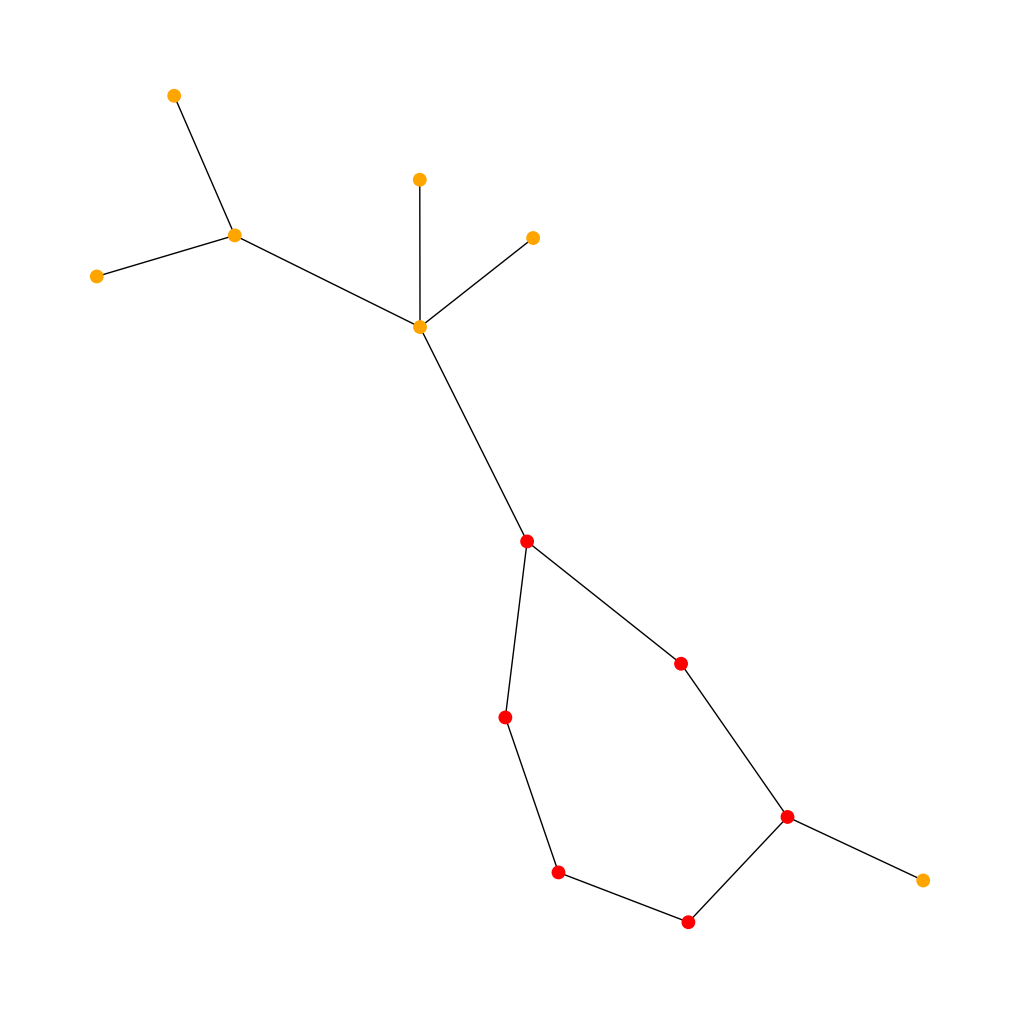

-----------Original Computational Graph with calculated Weights -----------


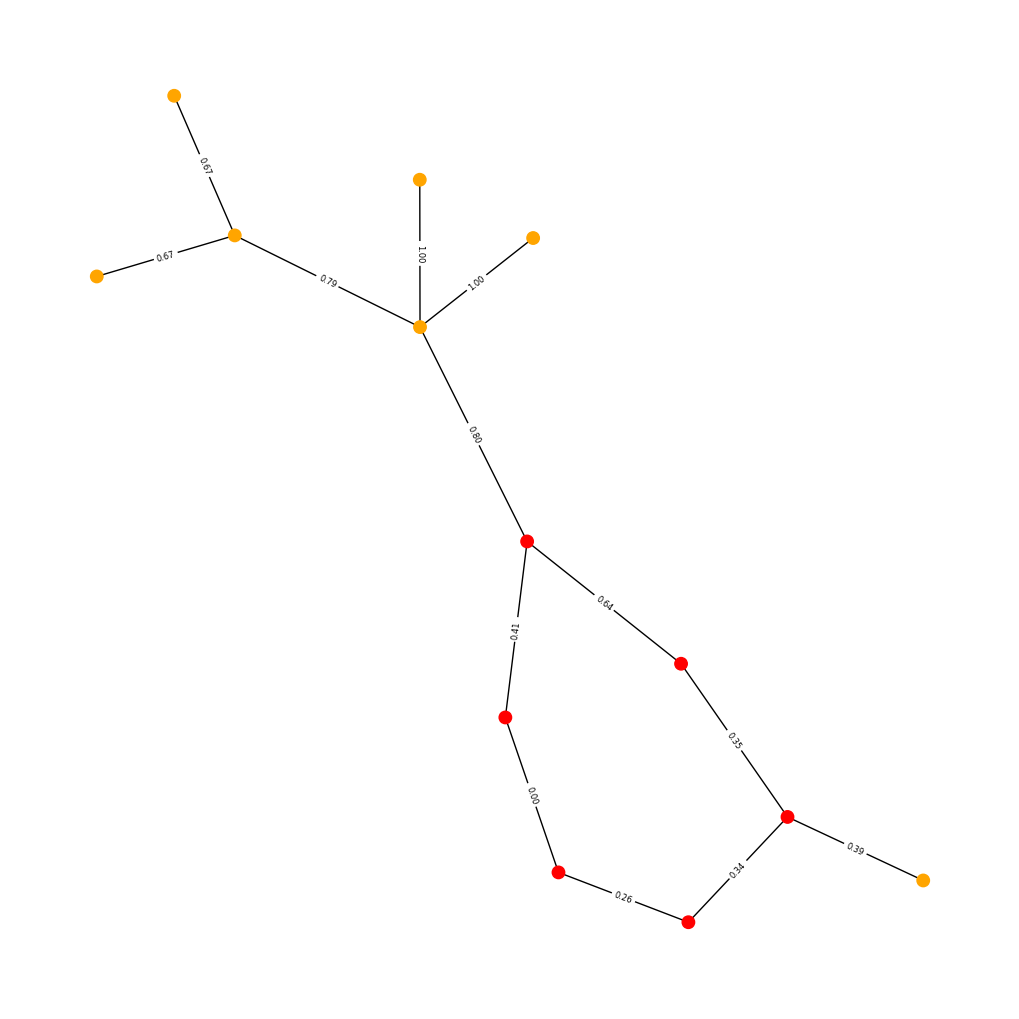

-----------------Top K Motif Graph-----------------


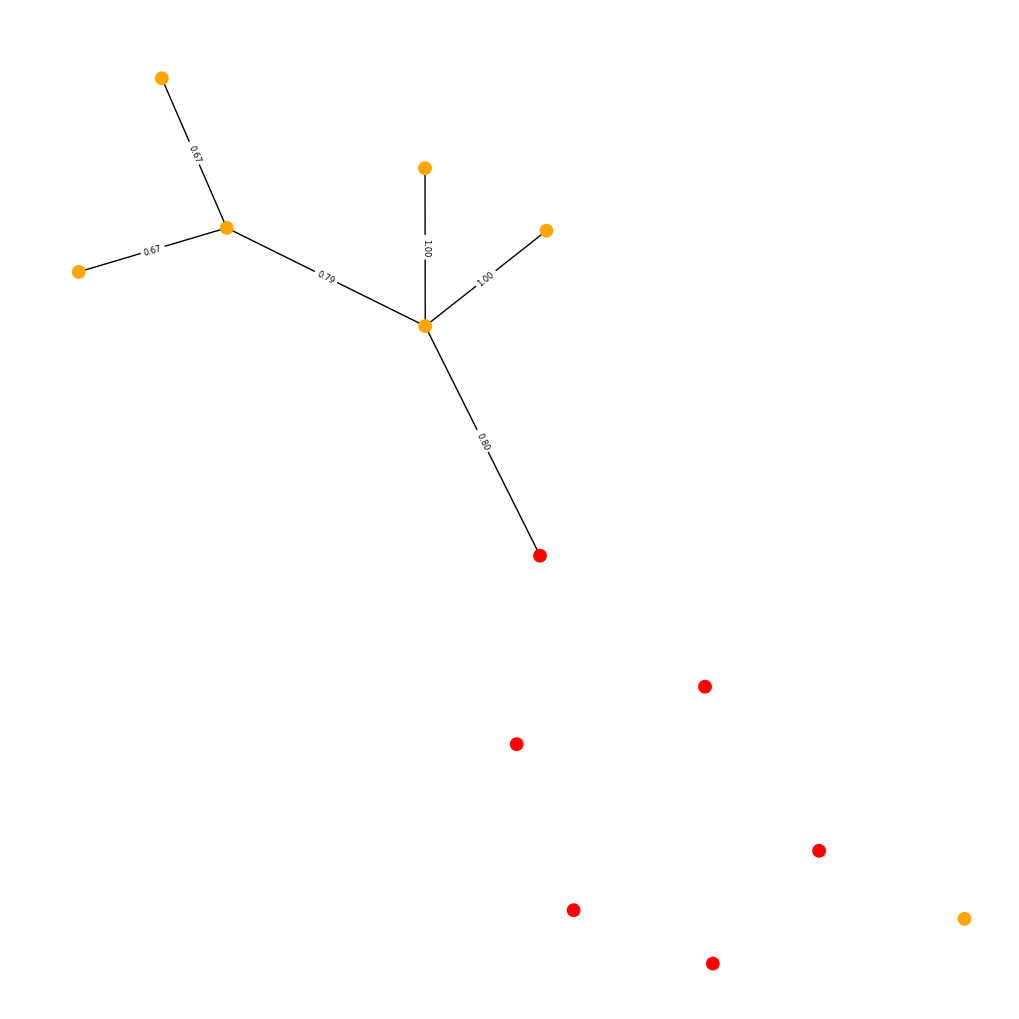

-----------------Ground Truth-----------------


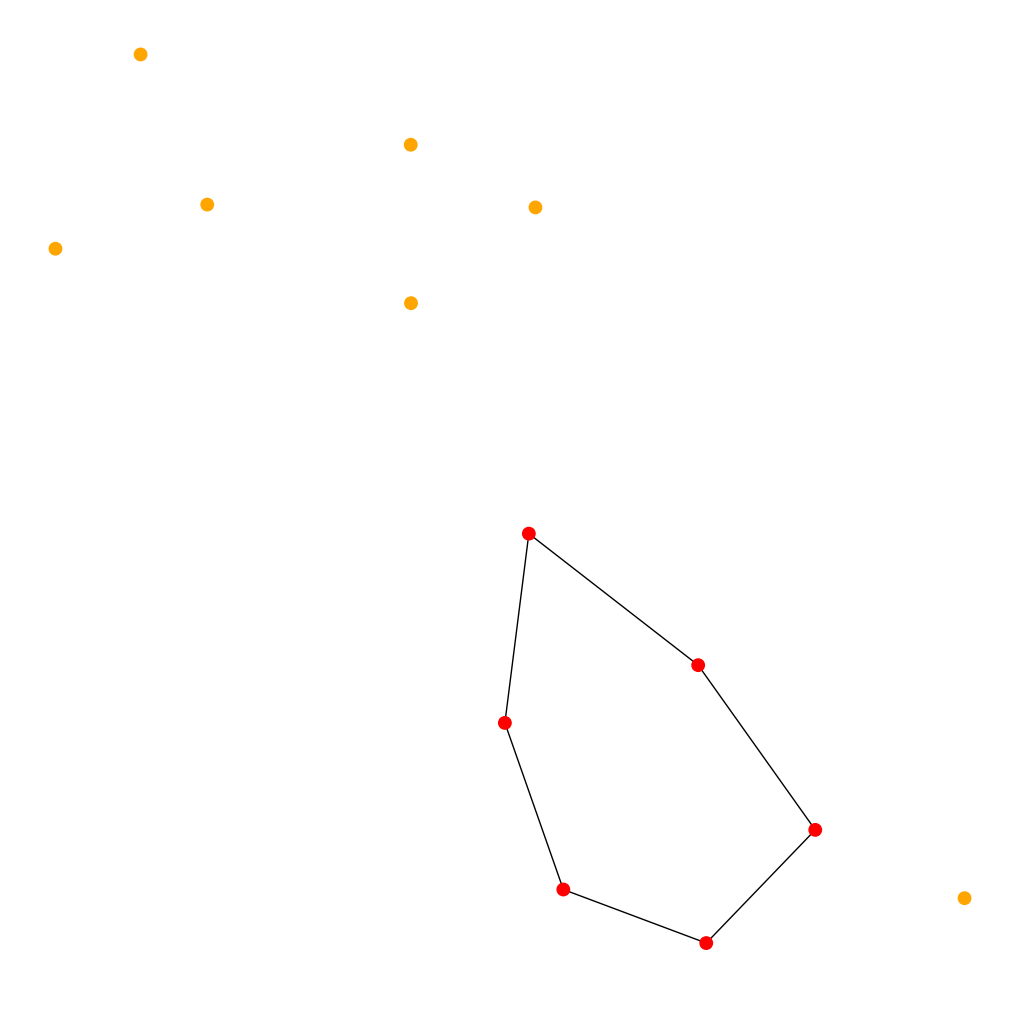

BinaryAUROC: 0.047619047619047616
roc_auc_score: 0.04761904761904763
Mean individual BinaryAUROC: 0.0476190485060215
AUC for random Node: 0.04761904761904763
Mean AUC for evaluation: 0.08741212521780928


In [15]:
importlib.reload(evaluation)

auc, ind_aucs, infTime = evaluation.evaluate(datasetName=dataset, mlp=mlp, downstreamTask=downstreamTask)

print(f"Mean AUC for evaluation: {auc}")

In [8]:
import wandb
wandb.finish()

In [10]:
import utils
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [14]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [16]:
k = 5

data1 = data

printLoader = DataLoader([data1], 1, False)

temperature = 1

In [17]:
mlp.eval()
downstreamTask.eval()

w_ij = mlp.forward(downstreamTask, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4110x120 and 180x64)

In [18]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [23]:
import random
import evaluation
from torch_geometric.utils import k_hop_subgraph

motifNodesOriginal = [i for i in range(400,700,5)]

randomAUCNode = random.choice(motifNodesOriginal)
currentAUC = randomAUCNode

AUC of ROC: 0.9920886158943176
BinaryAUROC: 0.9920886075949367
roc_auc_score: 0.9920886075949368
0.9920886075949368


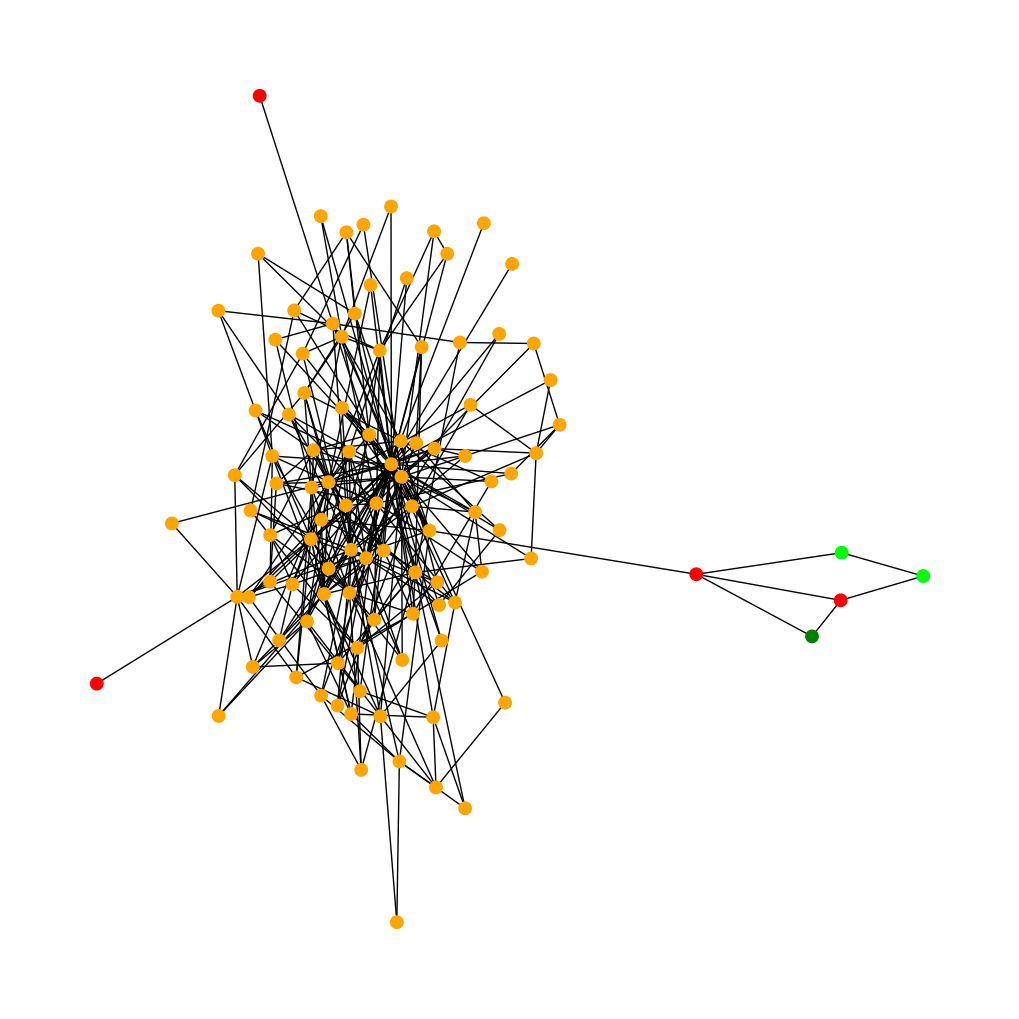

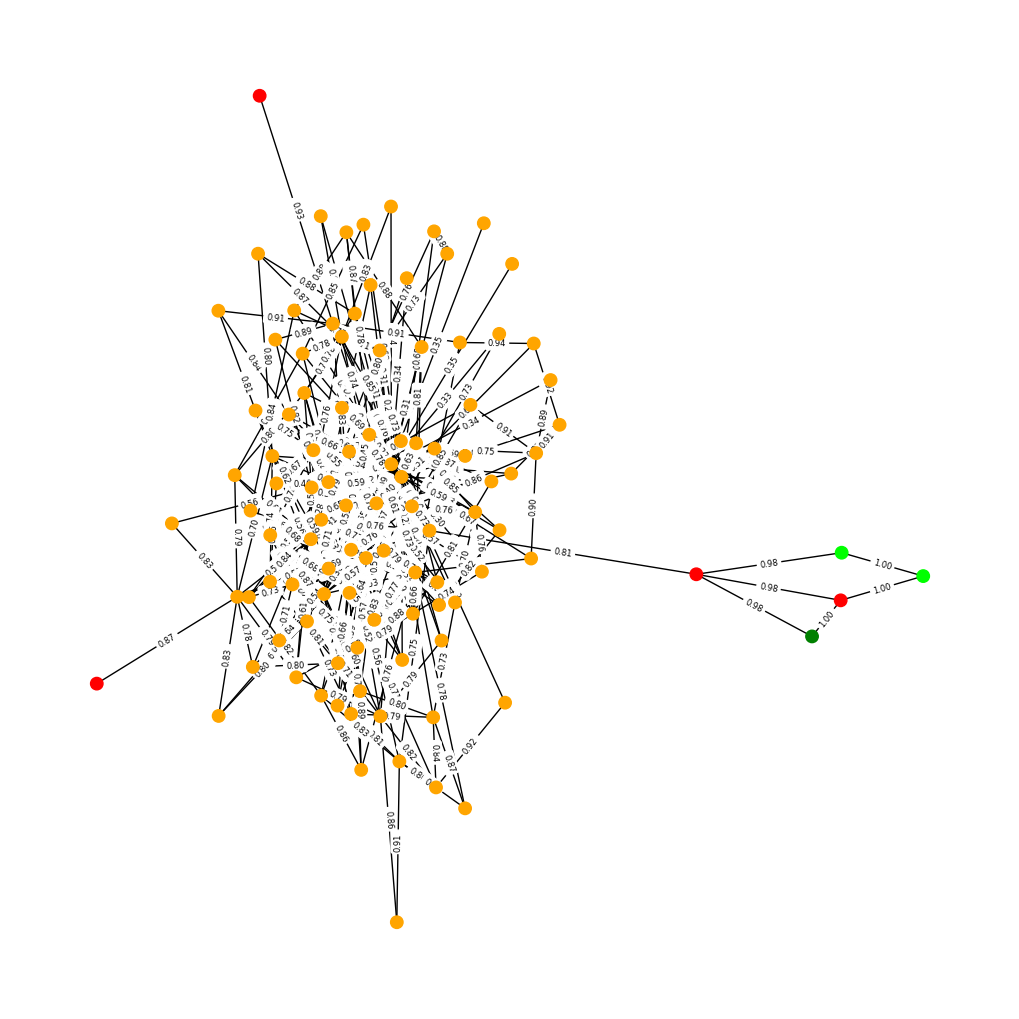

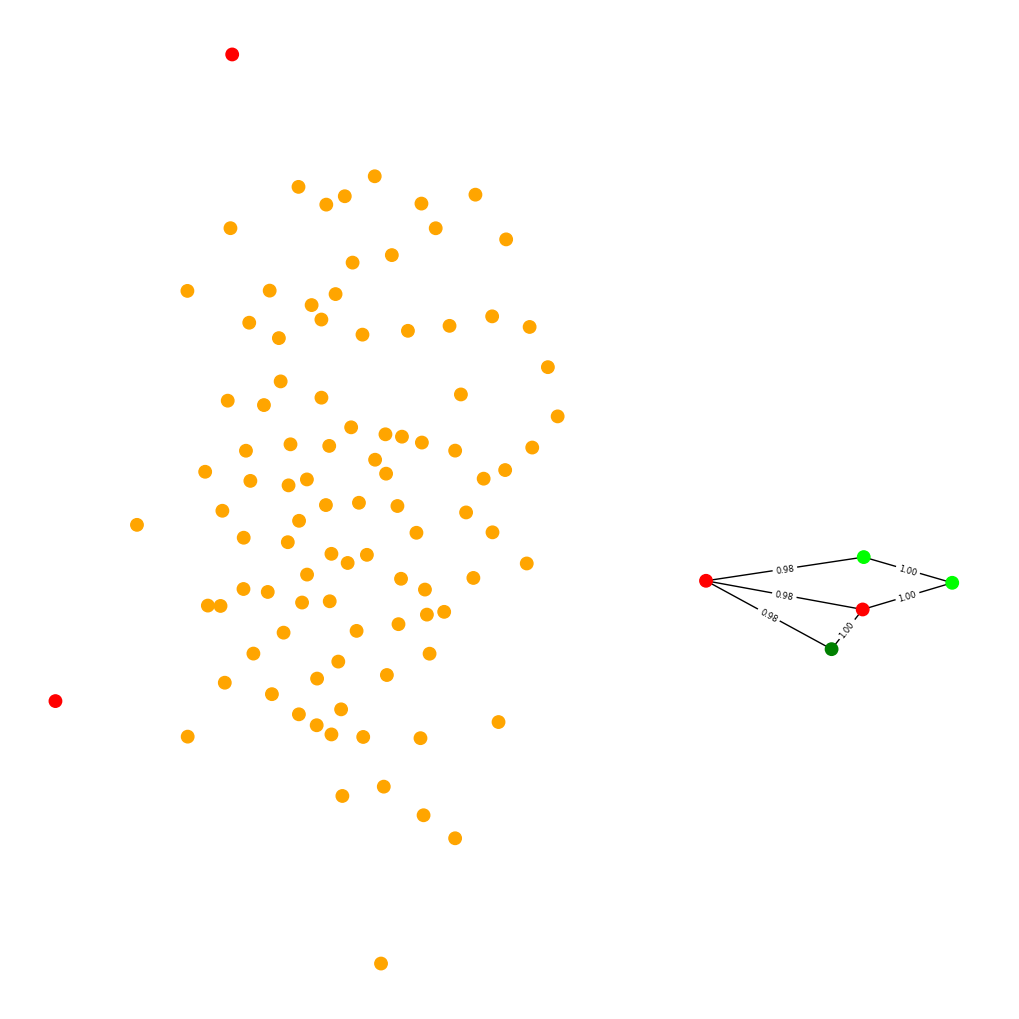

In [24]:
k = 6

mlp.eval()
downstreamTask.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]

#print(data.edge_index)

print(evaluation.evaluateNodeExplainerAUC(mlp, downstreamTask, data, data.edge_index, currentAUC, data.gt, k=k))

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotGraphAll(G_hop)




w_ij = mlp.forward(downstreamTask, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

#print(torch.unique(w_ij))
edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


GraphSampled = Data(x=G_hop.x, edge_index=G_hop.edge_index, y=G_hop.y, edge_attr=edge_ij.detach())

pos = utils.plotGraphAll(GraphSampled, pos, edge_weights=True)


# Print topK edges
k = k * 2 if len(w_ij) >= k*2 else len(w_ij)
_, top_k_indices = torch.topk(edge_ij, k=k, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, y=G_hop.y, edge_attr=weights_masked)

pos1 = utils.plotGraphAll(GtopK, pos=pos, color_map=None, edge_weights=True)